# ROSSMANN - PREVISÃO DE VENDAS

## Problema de Negócio

**Questão de negócio**

Qual será a receita de cada loja nas próximas seis semanas?

**Entendimento do Negócio**

O CFO pretende realizar investimentos para reformar as lojas, e, para determinar o valor do investimento, ele precisa saber quanto de receita cada loja vai gerar nas próximas seis semanas.

## 1.0 Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import inflection
import scipy.stats as ss
import math
from boruta import BorutaPy
import pickle

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error, mean_absolute_error
from sklearn.linear_model import LinearRegression, Lasso, Ridge
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor

from IPython.core.display import HTML
from IPython.display import Image
import datetime

import random
import warnings
from formulas import cramer_v, note_settings, ml_error, cross_valid_timeseries, mean_percentage_error

### 1.1 Configurações do Notebook

In [2]:
note_settings()
warnings.filterwarnings('ignore')

### 1.2 Carregando Dados

In [3]:
# 1.2 Loading Data
data_raw_sales = pd.read_csv(r'DATA\train.csv', low_memory=False)

data_raw_stores = pd.read_csv(r'DATA\store.csv', low_memory=False)

# Merge
df_raw = pd.merge(data_raw_sales, data_raw_stores, how='left', on='Store')

In [4]:
df_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)


## 2.0 Descrição dos Dados

In [5]:
df1 = df_raw.copy()

### 2.1 Renomeando Colunas

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))

# Rename

df1.columns = cols_new

### 2.2 Dimensão dos Dados

In [7]:
print(f'Number of rows: {df1.shape[0]}')
print(f'Number of Cols: {df1.shape[1]}')

Number of rows: 1017209
Number of Cols: 18


### 2.3 Tipos dos Dados

In [8]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

### 2.4 Checando Valores Faltantes

In [9]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

### 2.5 Preenchendo Valores Ausentes

In [10]:
# If the competition is too far away, we assume there is no competition.
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

# Filling the competition since month with the current month.
df1['competition_open_since_month'] = df1[['date', 'competition_open_since_month']].apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

# competition_open_since_year -> filling with the current year.
df1['competition_open_since_year'] = df1[['date', 'competition_open_since_year']].apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)
                    
# promo2_since_week -> filling with the current week
df1['promo2_since_week'] = df1[['date', 'promo2_since_week']].apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

# promo2_since_year - filling with the current year
df1['promo2_since_year'] = df1[['date', 'promo2_since_year']].apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

# promo_interval              
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sept', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

# Creating feature that says if it is in the beginning of promo2
df1['is_start_promo2'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

### 2.6 Alterando Tipos dos Dados

In [11]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_start_promo2                          int64
dtype: object

In [12]:
df1['competition_open_since_month' ] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

### 2.7 Estatística Descritiva

#### 2.7.1 Variáveis Numéricas

In [13]:
num_att = df1.select_dtypes(include=['int', 'float64'])
cat_att = df1.select_dtypes(exclude=['int', 'float64', 'datetime64[ns]'])

In [14]:
# Cetral Tendency - mean, median
# Dispersion - std, min. max, range, skew, kurtosis

num_att.agg(['min', 'max', 'ptp', 'mean', 'median', 'std', 'skew', 'kurtosis']).T.reset_index().rename(columns={'index': 'attributes', 'ptp': 'range'})

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908651,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997391,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.926175,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411734,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485759,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.652996,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311087,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515593,-7.235657,124.071304


#### 2.7.2 Distribuição da variável alvo

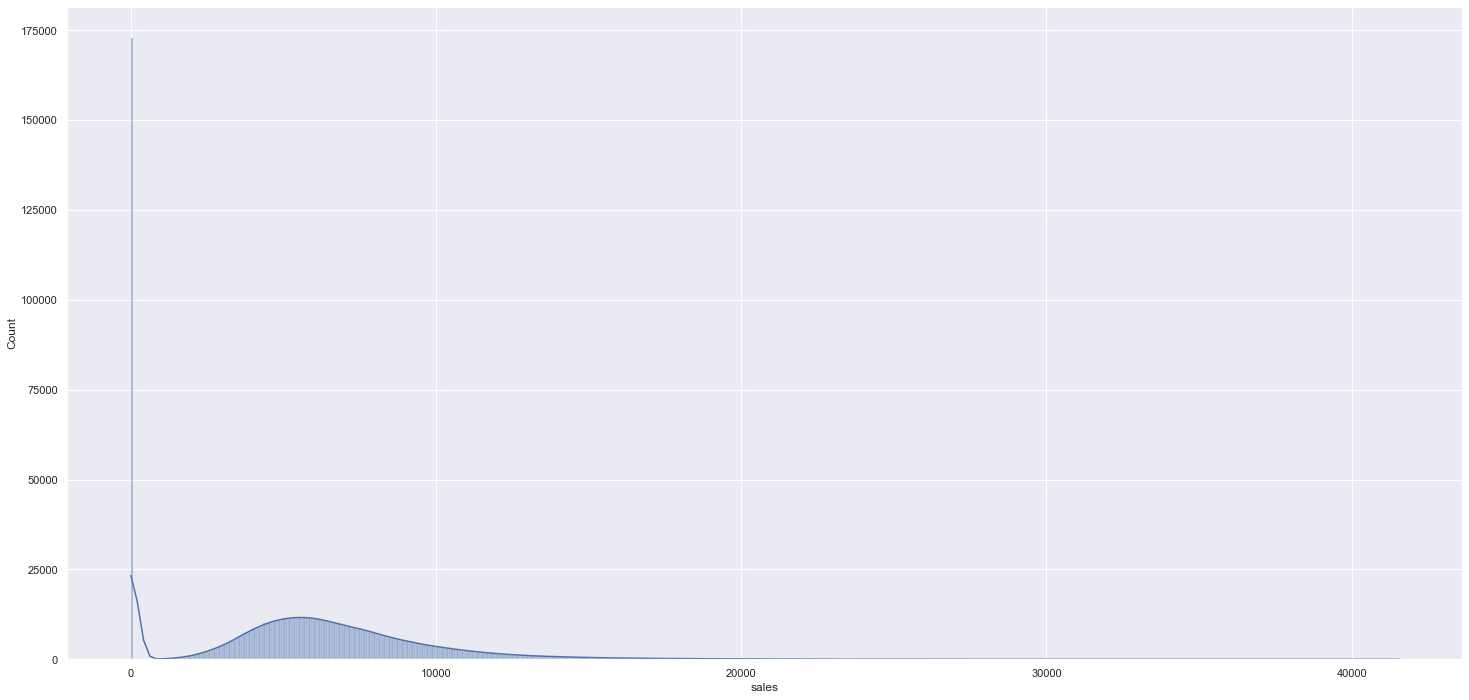

In [16]:
sns.histplot(df1['sales'], kde=True,);

O valor mais frequente é zero - dias em que as lojas estavam fechadas. Dias em que as lojas estavam fechadas serão removidos para a análise dos dados.

#### 2.7.1 Varáveis Categóricas

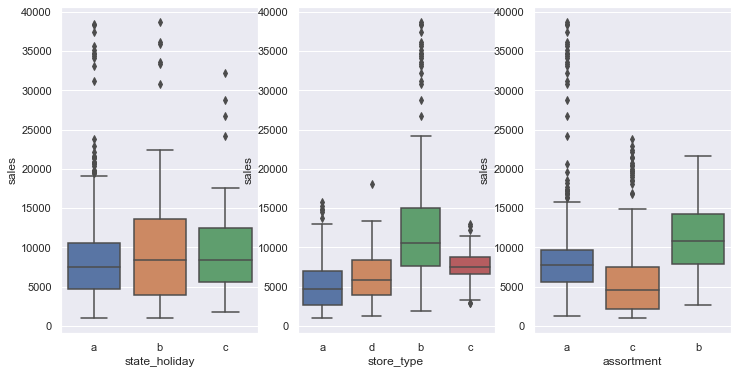

In [17]:
aux = df1.loc[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=aux)

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux)

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux);

## 3.0 Engenenharia de Atributos

In [18]:
df2 = df1.copy()

### 3.1 Mapa de Hipóteses

<img src='img/mind_map.png'/>

### 3.2 Hipóteses

#### 3.2.1 Loja

**1.** Lojas com maior quadro de funcionários deveriam vender mais.

**2.** Lojas com maior estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com competidores mais próximos deveriam vender menos.

**5.** Lojas com maior sortimento deveriam vender mais.

**6.** Lojas com competidores há mais tempo  deveriam vender mais.

#### 3.2.2 Produto

**1.** Lojas que investem mais em marketing deveriam vender mais.

**2.** Lojas que expõem mais os produtos na vitrine devem vender mais.

**3.** Lojas com que preços menores nos produtos deveriam vender mais.

**4.** Lojas com promoções mais agressivas deveriam vender mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

#### 3.2.3 Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados.

**7.** O ticket médio aumentou ao longo do tempo.

#### 3.2.4 Lista Final de Hipóteses

Hipóteses com informações disponíveis nos dados. 

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores há mais tempo  deveriam vender mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas que partipam da promo2 vendem mais no início da promoção 2.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados.

**13.** Lojas vendem mais no início da promoção 2.

**14.** Lojas vendem mais no início da semana.

**15.** O ticket aumentou ao longo do tempo.

### 3.3 Novos Atributos

In [19]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week'] = df2['date'].dt.isocalendar().week

# year week
df2['year_week'] = df2['date'].dt.strftime("%Y-%W")

# weekday
df2['weekday'] = df2['day_of_week'].apply(lambda x: 1 if x < 6 else 0)
 
# Competition time in months
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_since'] = pd.to_datetime(df2['competition_since'])

# divide by 30 then extract number of months.
df2['competition_time_month'] = df2.apply(lambda x: int(((x['date'] - x['competition_since'])/30).days), axis=1)

# promo since
# Merge the promo year and week
df2['promo2_since'] = df2['promo2_since_year'].astype('str') + '-' + df2['promo2_since_week'].astype('str')
df2['promo2_since'] = df2['promo2_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))

# Subtract from the date and divide by 7 (by week)
df2['promo2_time_week'] = ((df2['date'] - df2['promo2_since'])/7).apply(lambda x: int(x.days))

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

# average ticket
df2['ticket'] = df2['sales']/df2['customers']

## 4.0 Filtragem de Dados

Restrições de acordo com o Negócio.

In [20]:
df3 = df2.copy()

### 4.1 Filtragem das Linhas


Dias em que as lojas estavam fechadas ou em que as vendas foram zero serão excluídos do dataset.

In [21]:
df3 = df3.loc[(df3['open'] != 0) & (df3['sales'] > 0)]

### 4.2 Seleção das Colunas

Removendo colunas desnecessárias.

In [22]:
cols_drop = ['open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

## 5.0 Análise Exploratória de Dados

In [23]:
df4 = df3.copy()

### 5.1 Análise Univariada

#### 5.1.1 Variáveis Númericas

In [24]:
num_attributes = df4.select_dtypes(include=['int', 'float64'])
num_attributes.agg(['min', 'max', 'ptp', 'mean', 'median', 'std', 'skew', 'kurtosis']).T.reset_index().rename(columns={'index': 'attributes', 'ptp': 'range'})

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.000000,1115.000000,1114.00000,558.421374,558.00,321.730861,0.000426,-1.198836
1,day_of_week,1.000000,7.000000,6.00000,3.520350,3.00,1.723712,0.019310,-1.259347
2,sales,46.000000,41551.000000,41505.00000,6955.959134,6369.00,3103.815515,1.594929,4.854027
3,customers,8.000000,7388.000000,7380.00000,762.777166,676.00,401.194153,2.789062,13.318060
4,promo,0.000000,1.000000,1.00000,0.446356,0.00,0.497114,0.215824,-1.953425
5,school_holiday,0.000000,1.000000,1.00000,0.193578,0.00,0.395102,1.551109,0.405939
6,competition_distance,20.000000,200000.000000,199980.00000,5961.827515,2330.00,12592.181107,10.134908,145.288658
7,competition_open_since_month,1.000000,12.000000,11.00000,6.787355,7.00,3.309917,-0.048451,-1.231875
8,competition_open_since_year,1900.000000,2015.000000,115.00000,2010.331102,2012.00,5.502628,-7.217323,123.903078
9,promo2,0.000000,1.000000,1.00000,0.498670,0.00,0.499999,0.005320,-1.999976


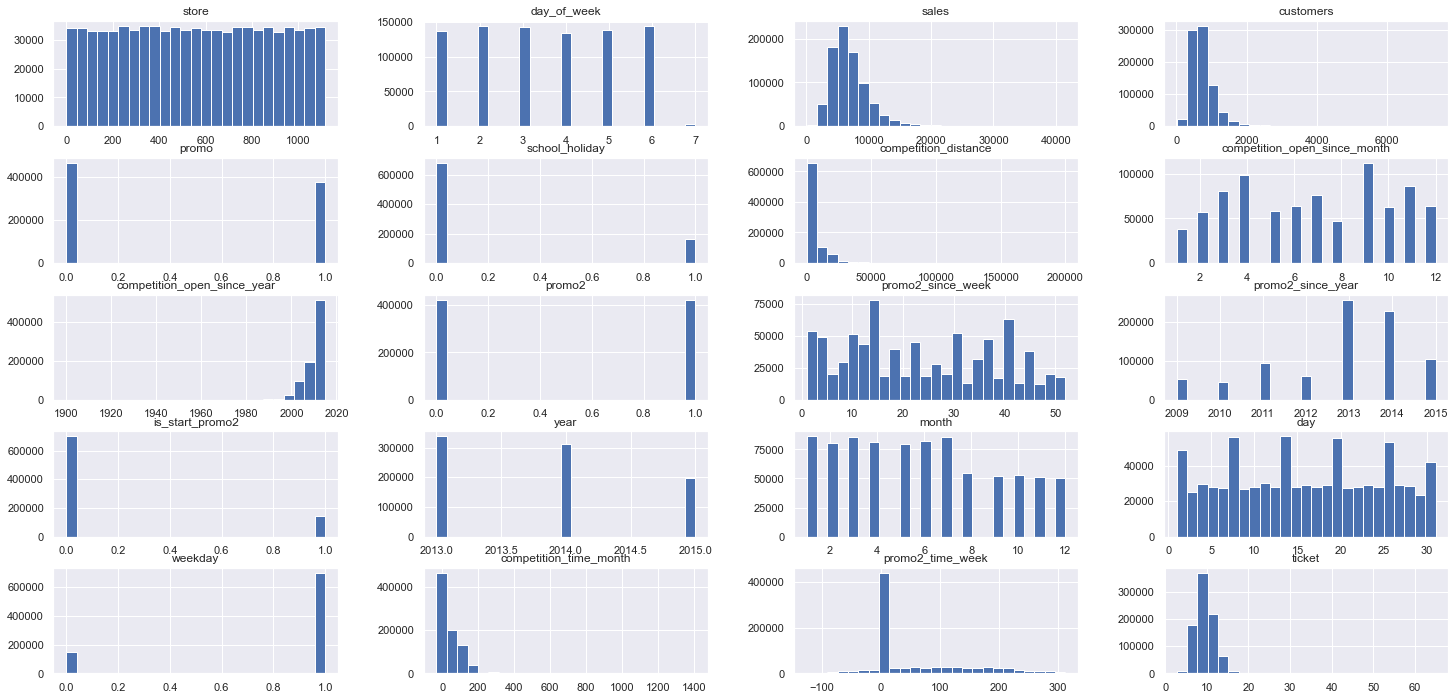

In [25]:
num_attributes.hist(bins=25);

- As vendas por loja seguem, basicamente, uma distribuição uniforme — não há muita variação no número de vendas entre as lojas.

- A distribuição dos dias da semana é uniforme, mas domingo aparece com uma frequênci muito menor - a maior parte das lojas não abrem aos domingos.

- A distribuição da quantidade de clientes está mais concentrada à esquerda. Até 1000 clientes em um dia por loja representa uma boa parcela da distribuição.

- A competição está concetrada mais próxima às lojas.

- A maior parte dos competidores começaram após o ano 2000, havendo uma concentração maior entre 2010 e 2020.

#### 5.1.2 Variável Alvo

<AxesSubplot:xlabel='sales', ylabel='Count'>

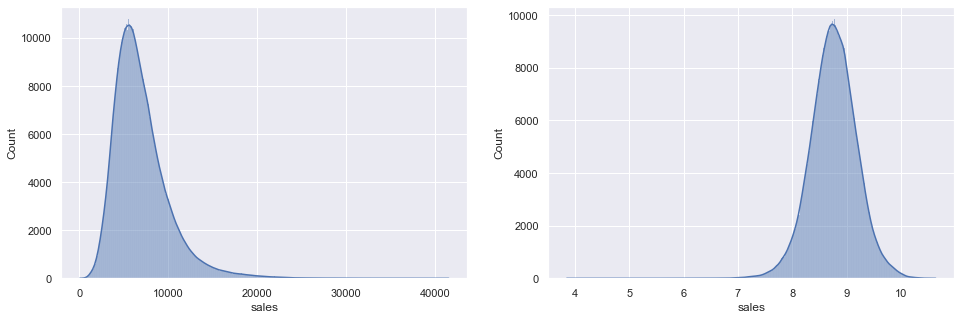

In [82]:
#plt.figure(figsize=(16,5))
fig, ax  = plt.subplots(1, 2, figsize=(16, 5))
sns.histplot(df4['sales'], kde=True, ax=ax[0])

# Quanto mais normal for a distribuição -> melhor será o algoritmo
# Log Transformation
sns.histplot(np.log1p(df4['sales']), kde=True, ax=ax[1])


É possível perceber que a distribuição é assimétrica à direita. Precisaremos realizar uma transformação na variável para que sua distribuição fique próxima de uma distribuição normal.

#### 5.1.3 Variáveis Categóricas

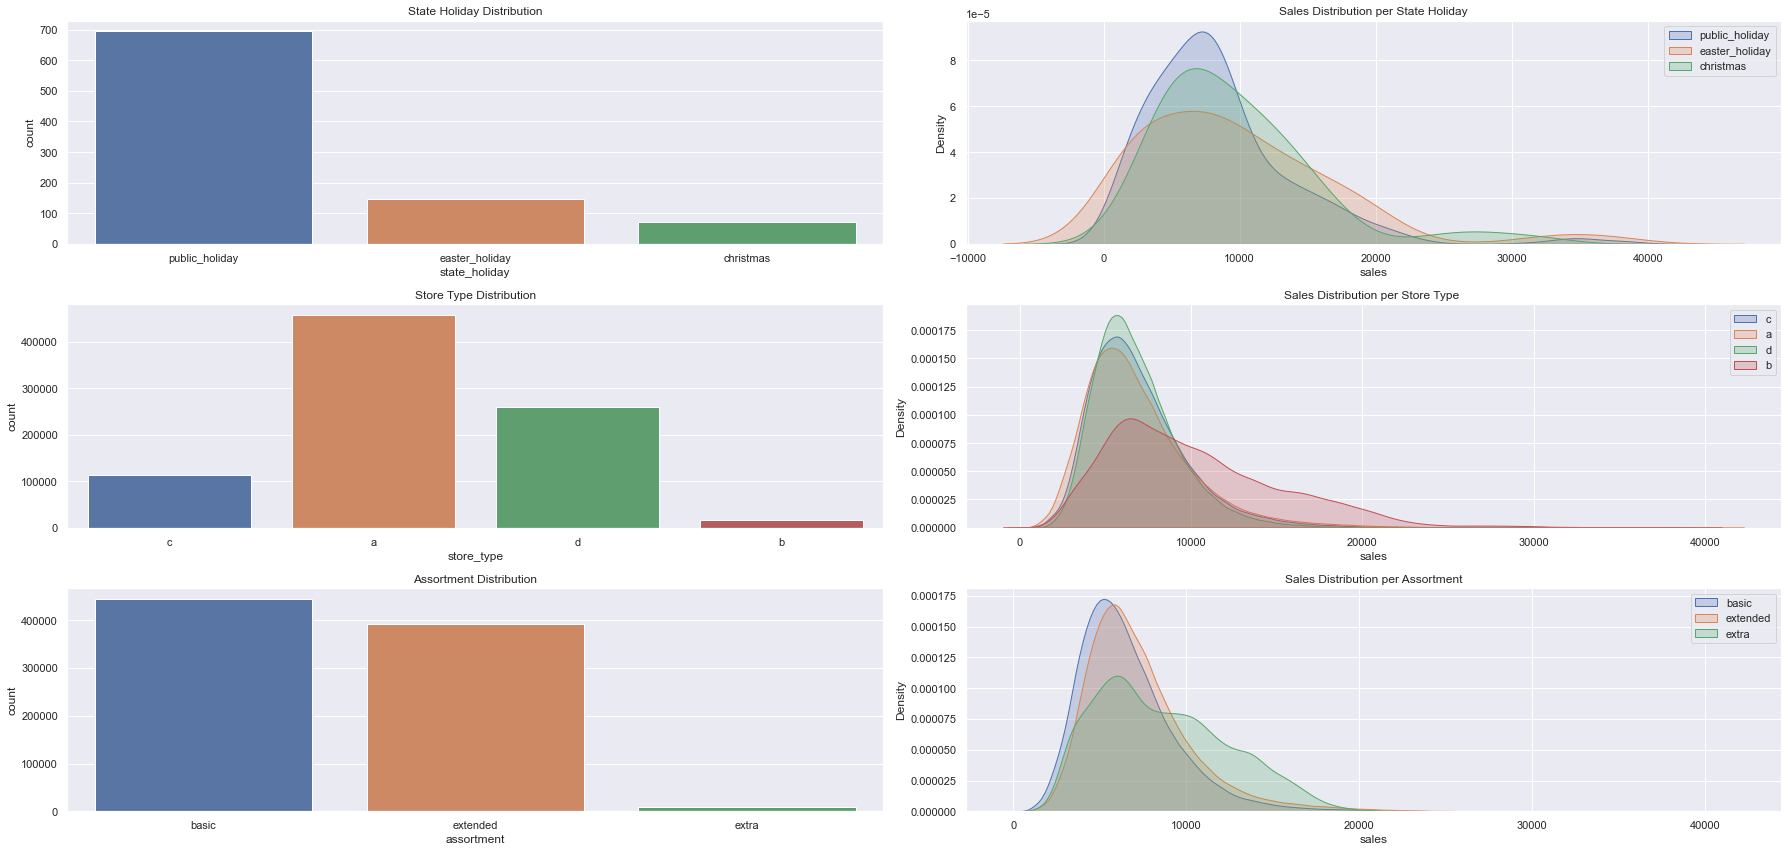

In [27]:
#state_holiday
plt.subplot(3, 2, 1)
aux = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(x=aux['state_holiday'])
plt.title('State Holiday Distribution')

plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], shade=True, label='public_holiday')
sns.kdeplot(df4[df4['state_holiday']== 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday']== 'christmas']['sales'], label='christmas', shade=True)
plt.title('Sales Distribution per State Holiday')
plt.legend()

#store_type 
plt.subplot(3, 2, 3)
sns.countplot(x=df4['store_type'])
plt.title('Store Type Distribution')


plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c',  shade=True,)
sns.kdeplot(df4[df4['store_type']== 'a']['sales'], label='a', shade=True)
sns.kdeplot(df4[df4['store_type']== 'd']['sales'], label='d', shade=True)
sns.kdeplot(df4[df4['store_type']== 'b']['sales'], label='b', shade=True)
plt.title('Sales Distribution per Store Type ')
plt.legend()

#assortment 
plt.subplot(3, 2, 5)
sns.countplot(x=df4['assortment'])
plt.title('Assortment Distribution')

plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic',  shade=True,)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True)
plt.title('Sales Distribution per Assortment')
plt.legend()

plt.tight_layout()
plt.show()

### 5.2 Análise Bivariada

#### **H1.** Lojas com maior sortimento deveriam vender mais.

VERDADE: Lojas com maior sortimento tem média maior de vendas.
obs: Há apenas 9 lojas com o tipo de sortimento extra.


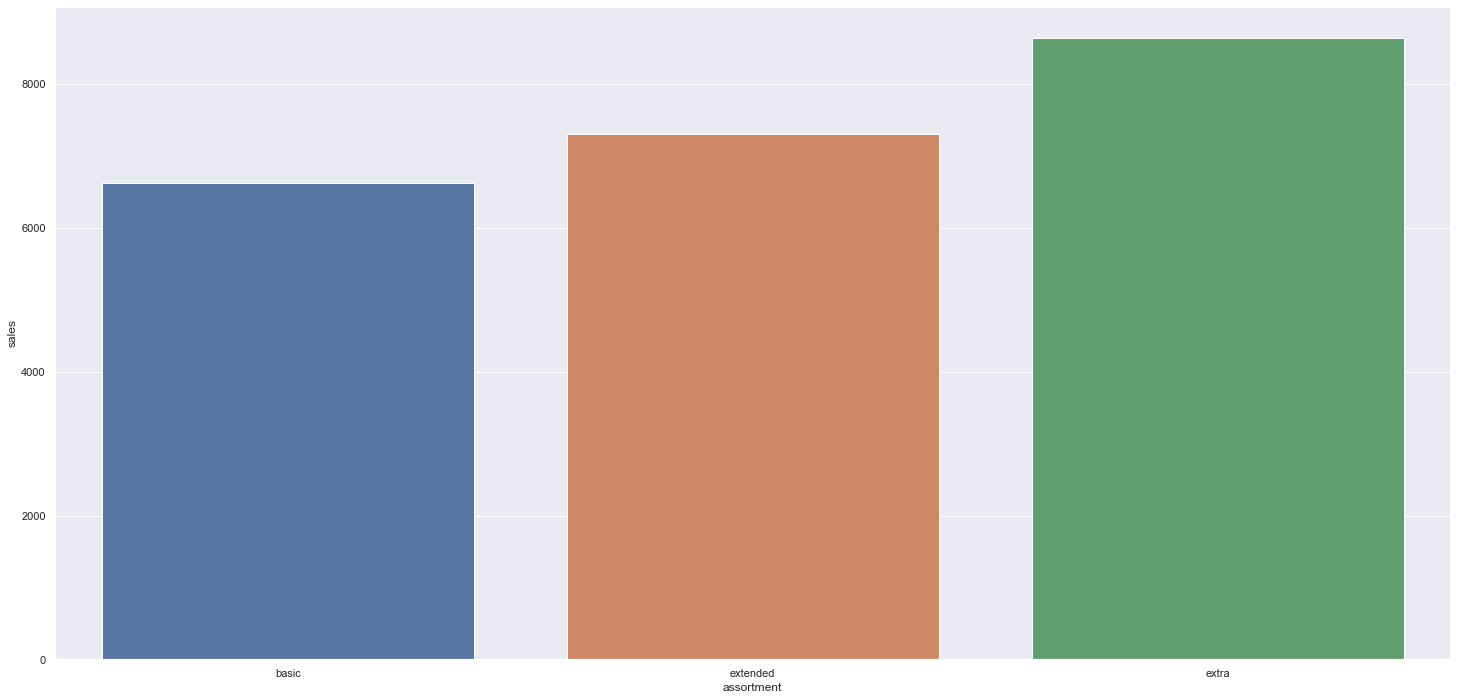

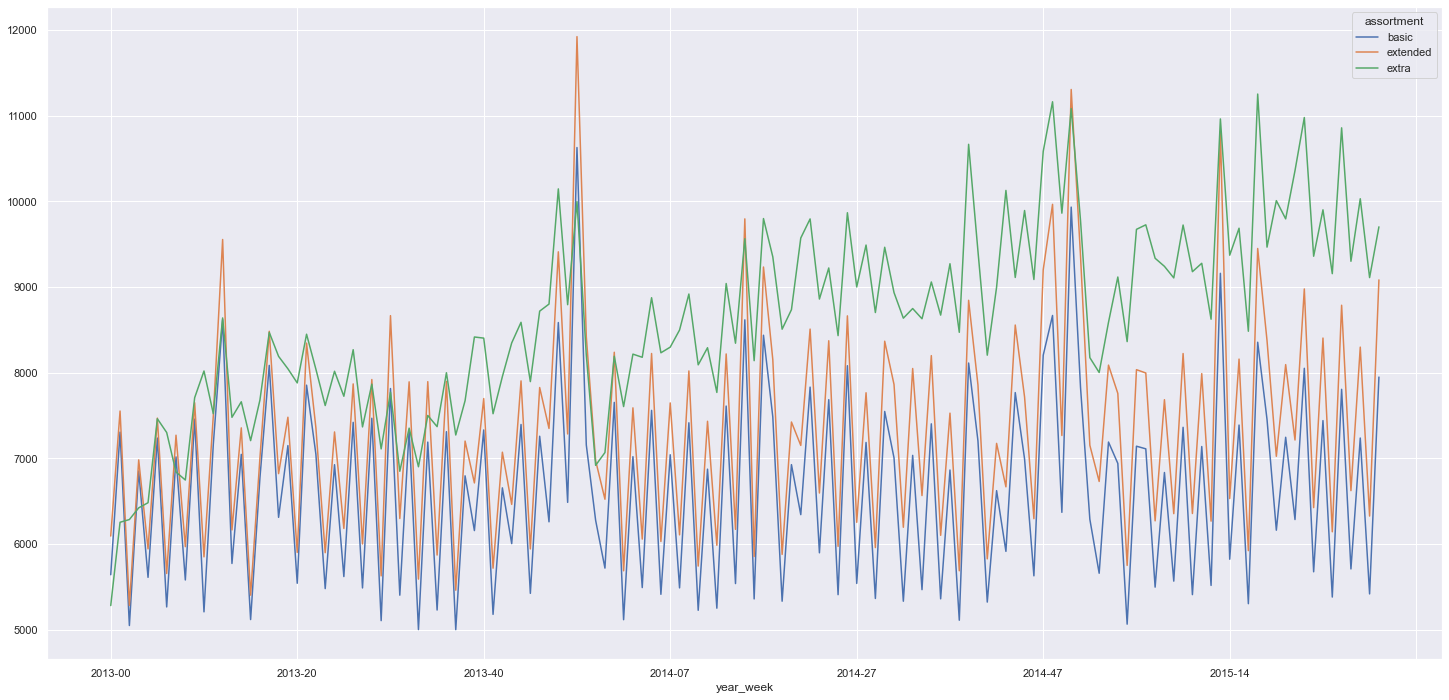

In [28]:
aux_1 = df4[['assortment', 'sales']].groupby('assortment').mean().reset_index()
sns.barplot(x='assortment', y='sales', data=aux_1)

aux_2 = df4[['year_week','assortment', 'sales']].groupby(['year_week', 'assortment']).mean().reset_index()
aux_2.pivot(index='year_week', columns='assortment', values='sales').plot();

#### **H2.** Lojas com competidores mais próximos deveriam vender menos.
FALSO: Lojas com competidores mais próximo vendem mais.

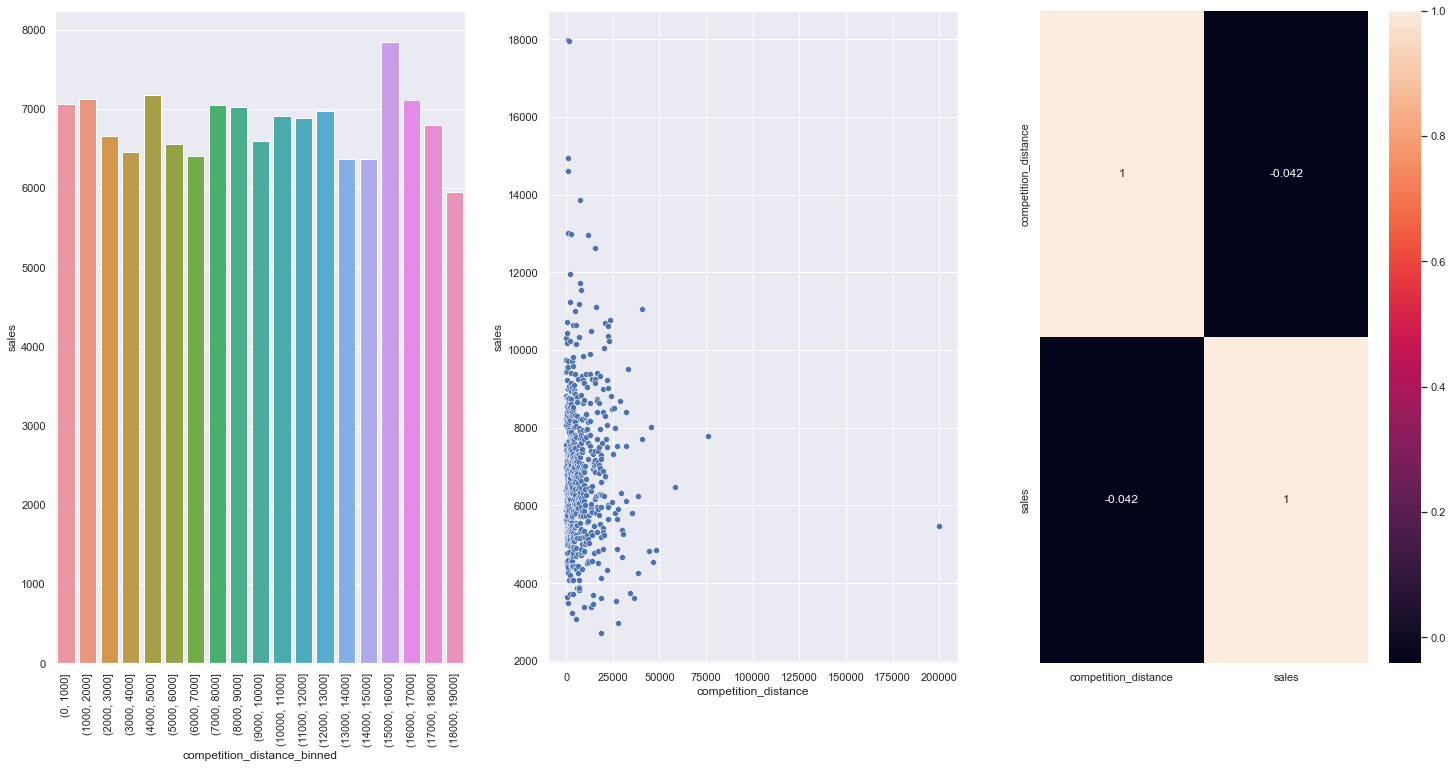

In [29]:
comp_aux = df4[['competition_distance', 'sales']].groupby('competition_distance').mean().reset_index()
bins = list(np.arange(0, 20000, 1000))
comp_aux['competition_distance_binned'] = pd.cut(comp_aux['competition_distance'], bins=bins)
comp_aux2 = comp_aux[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').mean().reset_index()
plt.subplot(1, 3, 1)
sns.barplot(x='competition_distance_binned', y='sales', data=comp_aux2)
plt.xticks(rotation=90);

# Scatter Plot
plt.subplot(1, 3, 2)
sns.scatterplot(x='competition_distance', y='sales', data=comp_aux);
# Correlation
plt.subplot(1, 3, 3)
sns.heatmap(df4[['competition_distance', 'sales']].corr(method='pearson'), annot=True);

#### **H3.** Lojas com competidores há mais tempo  deveriam vender mais.
VERDADE: Lojas com competidores há mais tempo vendem mais

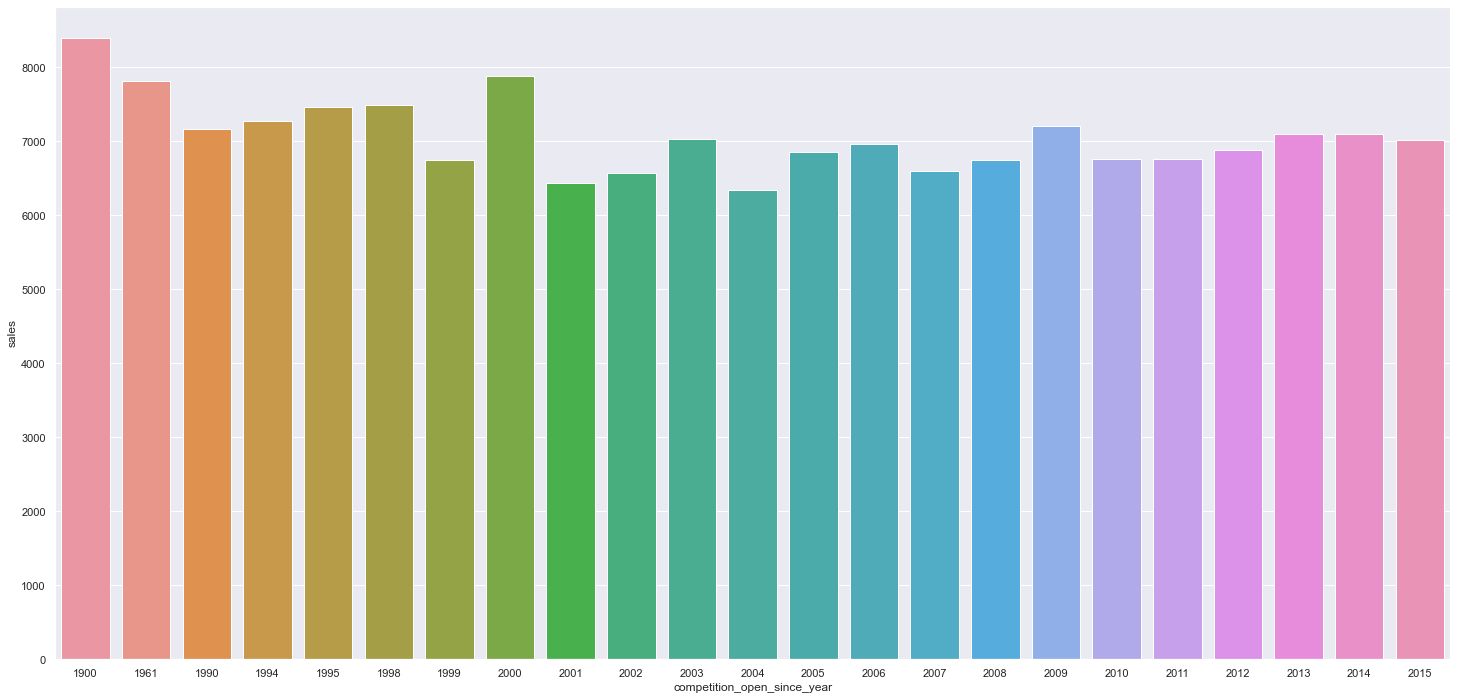

In [30]:
time_aux = df4[['competition_open_since_year', 'sales']].groupby('competition_open_since_year').mean().reset_index()
sns.barplot(x='competition_open_since_year', y='sales', data=time_aux);

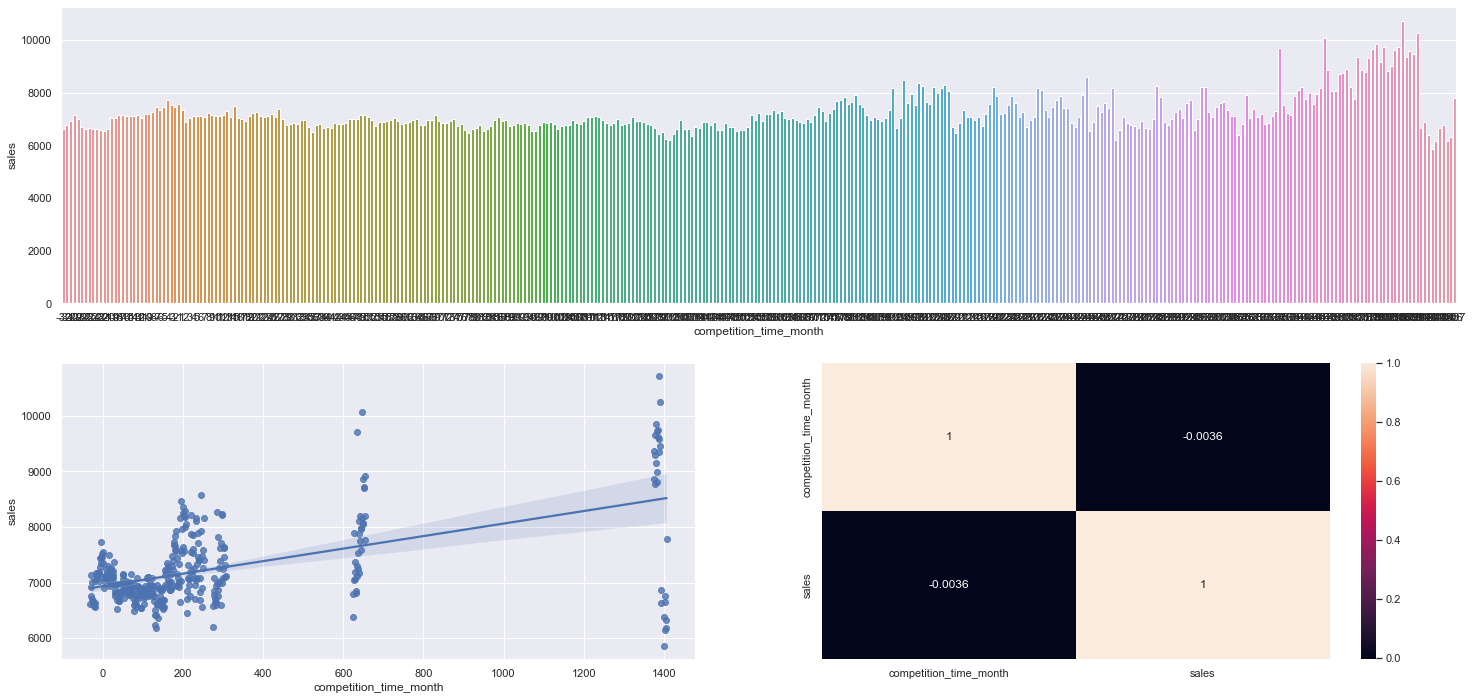

In [31]:
time_aux = df4[['competition_time_month', 'sales']].groupby('competition_time_month').mean().reset_index()
time_aux = time_aux[(time_aux['competition_time_month'] !=0)]
grid = GridSpec(2, 2)
plt.subplot(grid[0,:])
sns.barplot(x='competition_time_month', y='sales', data=time_aux)
plt.subplot(grid[1,0])
sns.regplot(x='competition_time_month', y='sales', data=time_aux)
plt.subplot(grid[1,1])
sns.heatmap(df4[['competition_time_month', 'sales']].corr(method='pearson'), annot=True);

#### **H4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

VERDADE: Há crescimento das vendas quando a promoção fica ativa por mais tempo.


Se o promo_time_week for negativo quer dizer que as compras foram feitas no período em que a loja não havia aderido à promoção 2, se for positivo, foram feitas no período pós promoção 2.

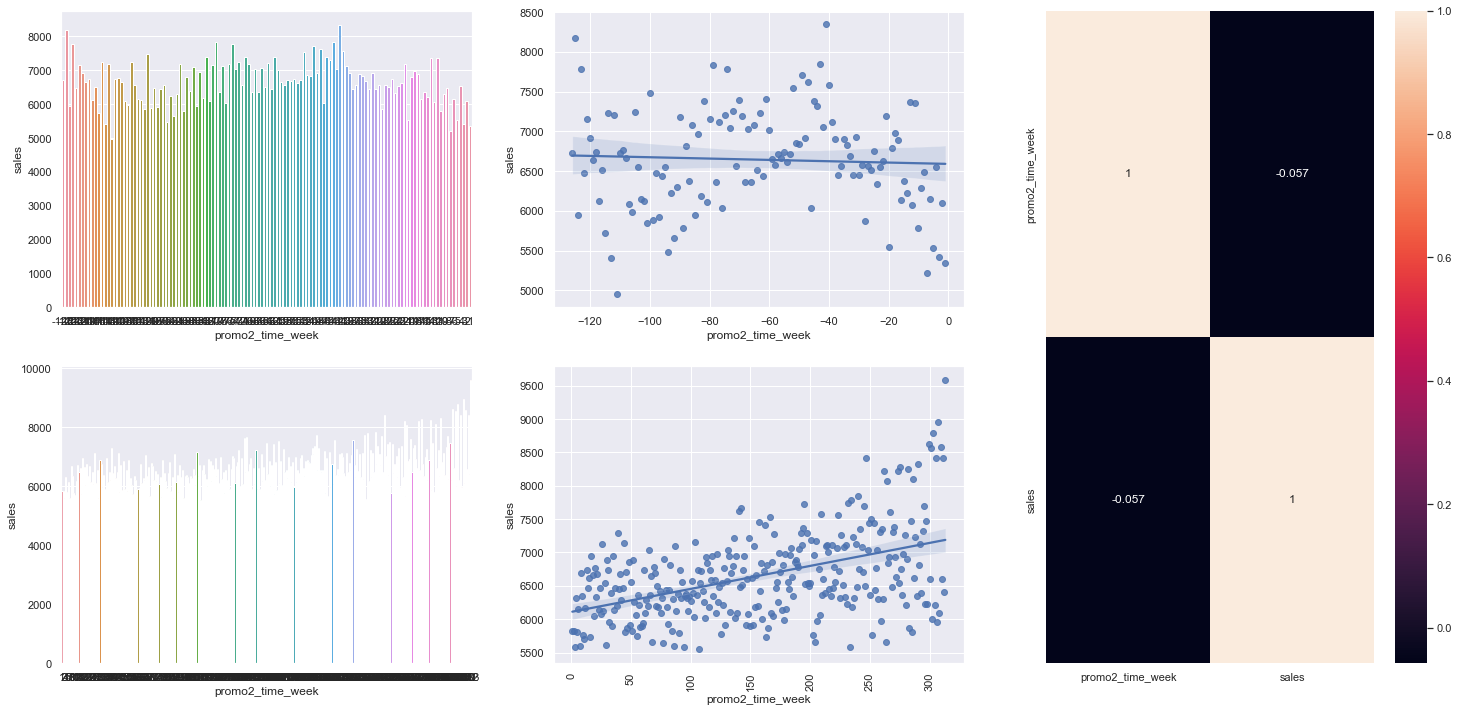

In [32]:
grid = GridSpec(2, 3)

df_promo = df4[['promo2_time_week', 'sales']].groupby('promo2_time_week').mean().reset_index()

df_promo2 = df_promo.loc[df_promo['promo2_time_week'] > 0]
df_promo_reg = df_promo.loc[df_promo['promo2_time_week'] < 0]

plt.subplot(grid[0, 0])
sns.barplot(x='promo2_time_week',y='sales', data=df_promo_reg)

plt.subplot(grid[0, 1])
sns.regplot(x='promo2_time_week',y='sales', data=df_promo_reg)

plt.subplot(grid[1, 0])
sns.barplot(x='promo2_time_week',y='sales', data=df_promo2)

plt.subplot(grid[1, 1])
sns.regplot(x='promo2_time_week',y='sales', data=df_promo2)
plt.xticks(rotation=90)

plt.subplot(grid[:, 2])
sns.heatmap(df4[['promo2_time_week', 'sales']].corr(method='pearson'), annot=True);


#### **H5.**: Lojas que participam da promo2 vendem mais no início da promoção 2.

FALSO: A média de vendas não é maior nos meses de início da promoção 2.

obs: Em 2015 isso se inverteu, mas só temos dados até 31/07.

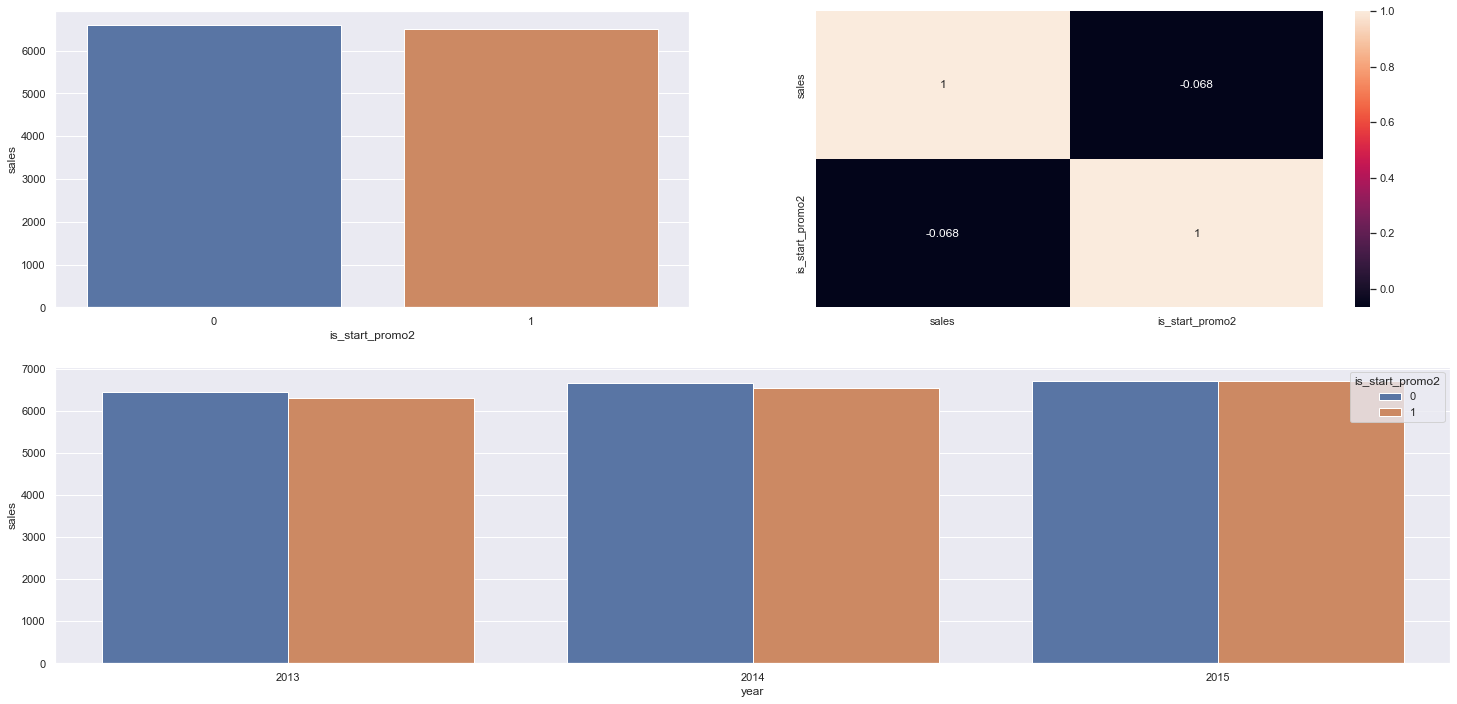

In [33]:
aux = df4.query('promo2 == 1')
aux_1 = aux[['is_start_promo2', 'sales']].groupby('is_start_promo2').mean().reset_index()

aux_2_year = aux[['year', 'is_start_promo2', 'sales']].groupby(['year', 'is_start_promo2']).mean().reset_index()

grid = GridSpec(2, 2)
plt.subplot(grid[0, 0])
sns.barplot(x='is_start_promo2', y='sales', data=aux_1)

plt.subplot(grid[0, 1])
sns.heatmap(df4[['sales', 'is_start_promo2']].corr(method='pearson'), annot=True)

plt.subplot(grid[1, :])
sns.barplot(x='year', hue='is_start_promo2', y='sales', data=aux_2_year);

#### **H6.** Lojas com mais promoções consecutivas deveriam vender mais.

FALSA: Lojas com promoções consecutivas tem média de vendas menor.


In [34]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).mean().reset_index().sort_values('sales')

,promo,promo2,sales
1,0,1,5529.566684
0,0,0,6328.187633
3,1,1,7836.672987
2,1,0,8618.452062


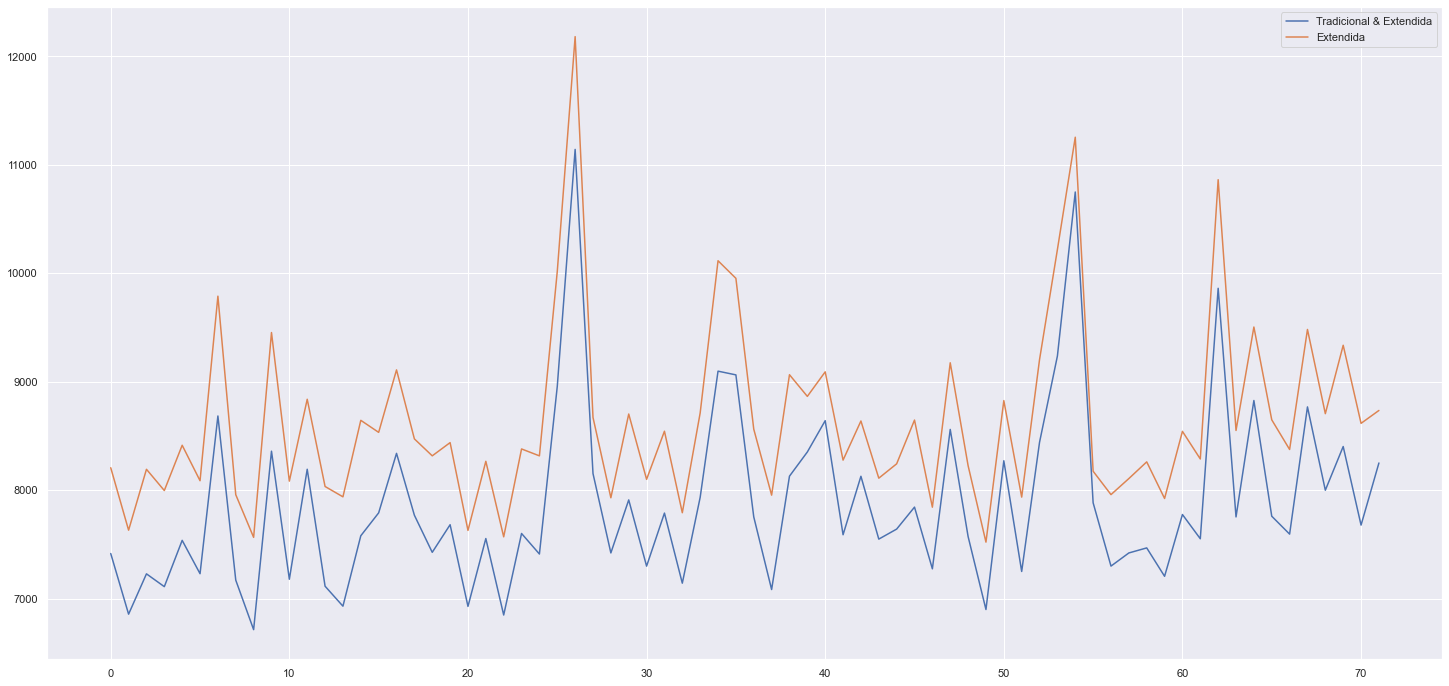

In [35]:
aux1 = df4.loc[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').mean().reset_index()
ax = aux1.plot()

aux2 = df4.loc[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').mean().reset_index()
aux2.plot(ax=ax)

ax.legend(labels=['Tradicional & Extendida', 'Extendida']);

#### **H7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

VERDADE -> A média de vendas no natal é maior.

Como não temos os dados do natal em 2015, esse ano foi filtrado para a análise.

In [36]:
df_chris = df4.query('date < "2015/01/01"')
df_hol = df_chris[['state_holiday', 'sales']].groupby('state_holiday').mean().reset_index()#.sort_values('sales')

df_hol_year = df_chris[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).mean().reset_index()#.sort_values('sales')

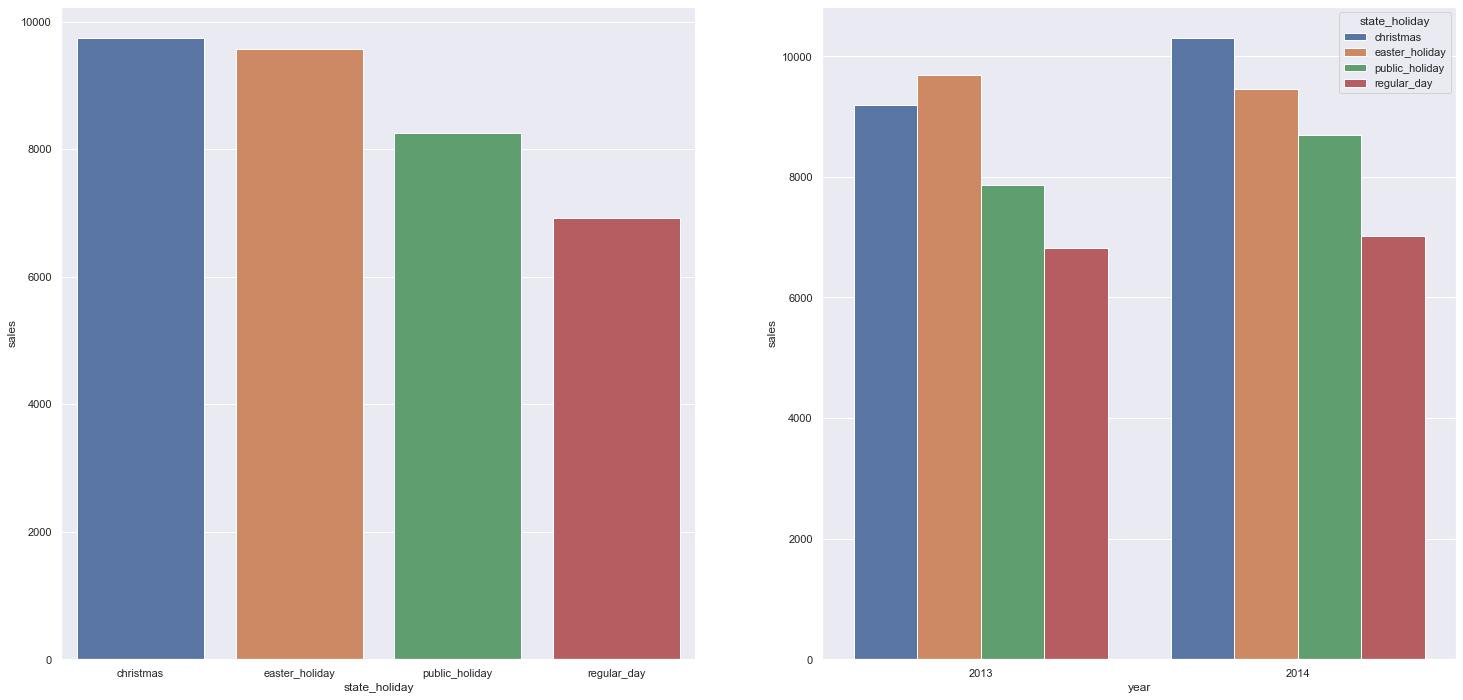

In [37]:
plt.subplot(1, 2, 1)
sns.barplot(x='state_holiday', y='sales', data=df_hol)
plt.subplot(1, 2, 2)
sns.barplot(x='year', hue='state_holiday', y='sales', data=df_hol_year);

Em 2013, a média de vendas foi maior na páscoa e em 2014 a média no natal foi maior.

#### **H8.** Lojas deveriam vender mais ao longo dos anos.
FALSO -> Houve uma redução de número de vendas de 2013 para 2014, embora a média de vendas em 2014 tenha sido maior.


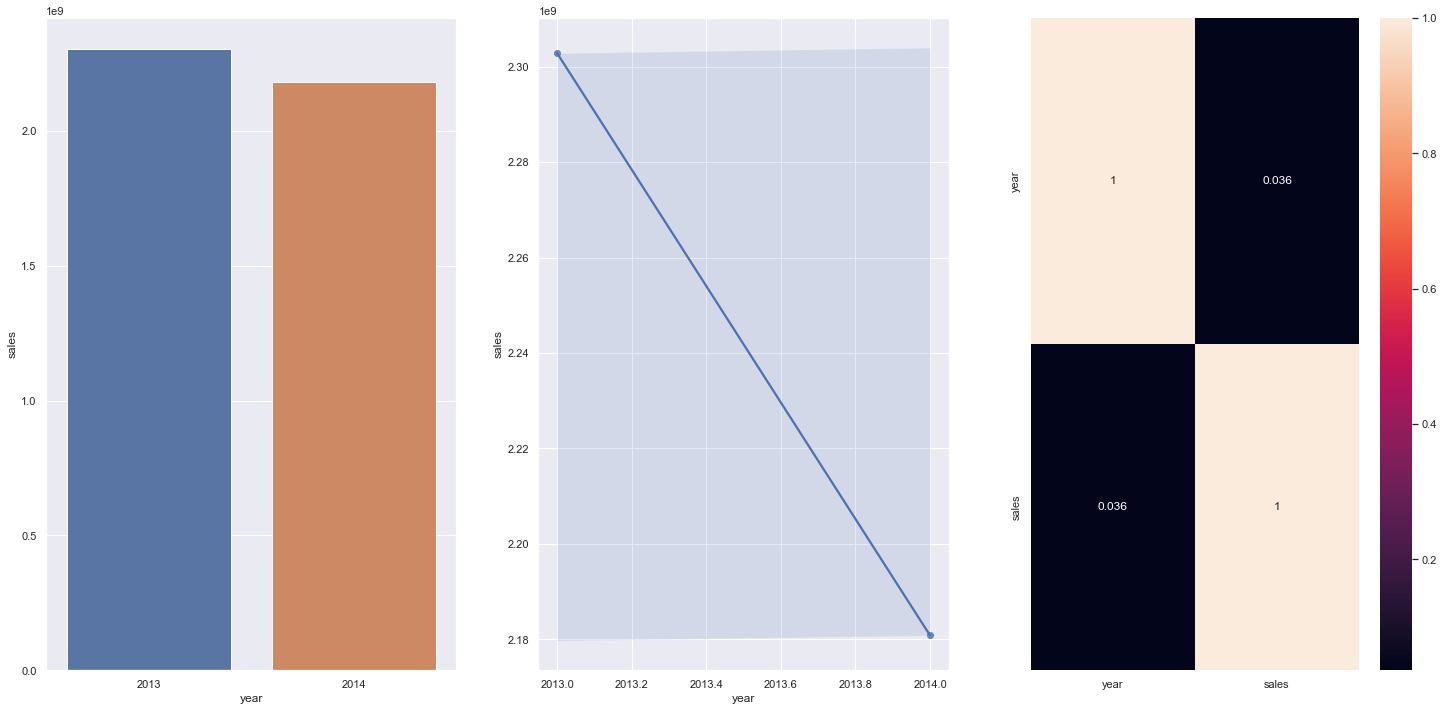

In [38]:
df_year = df4.query('year < 2015')[['year', 'sales']].groupby('year').sum().reset_index()
plt.subplot(1, 3, 1)
sns.barplot(x='year', y='sales', data=df_year)
plt.subplot(1, 3, 2)
sns.regplot(x='year', y='sales', data=df_year)
plt.subplot(1, 3, 3)
sns.heatmap(df4[['year', 'sales']].corr(method='pearson'),annot=True);

#### **H9.** Lojas deveriam vender mais no segundo semestre.

VERDADE -> As lojas têm maior receita no segundo semestre.

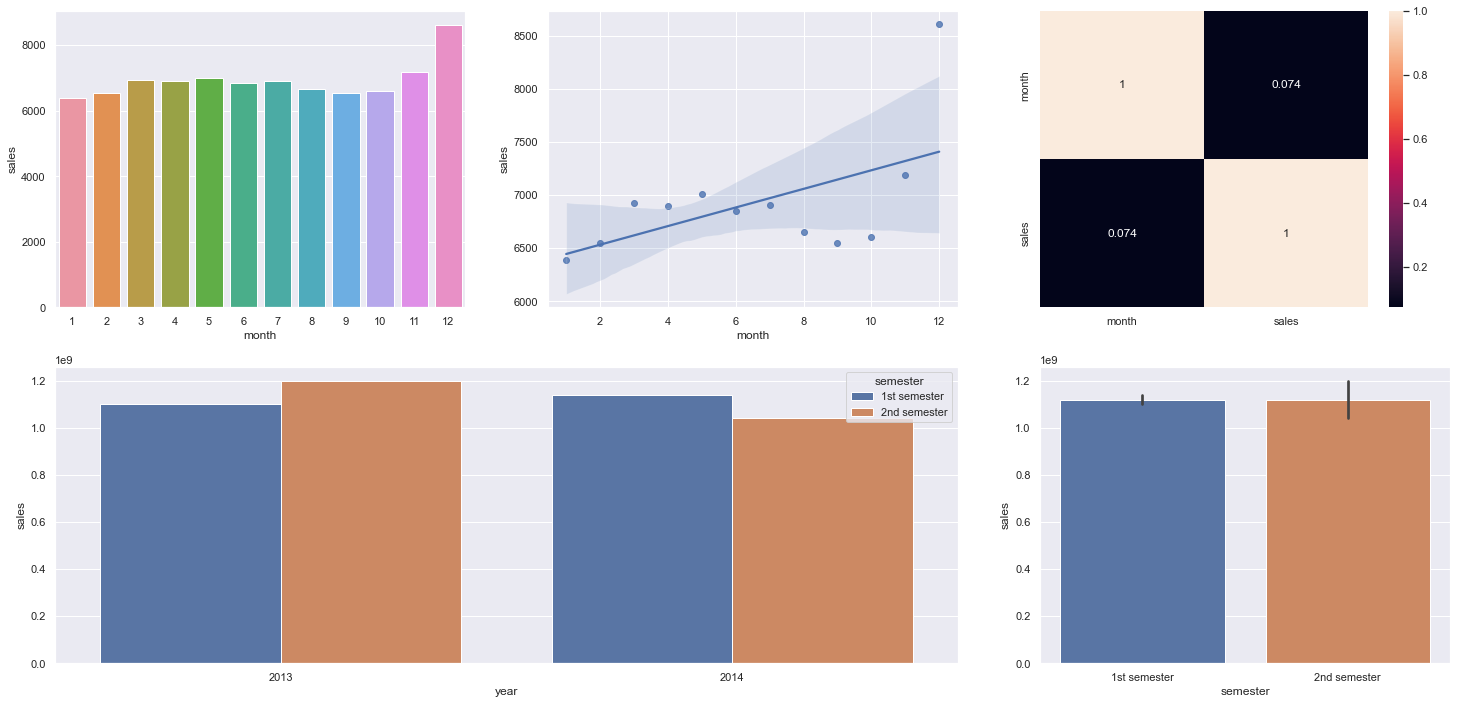

In [39]:
grid = GridSpec(2, 3)
df_aux = df4.query('year < 2015')
df_month = df4.query('year < 2015')[['month', 'sales']].groupby('month').mean().reset_index()
plt.subplot(grid[0, 0])
sns.barplot(x='month', y='sales', data=df_month)
plt.subplot(grid[0, 1])
sns.regplot(x='month', y='sales', data=df_month)
plt.subplot(grid[0,2])
sns.heatmap(df4[['month', 'sales']].corr(method='pearson'),annot=True)
df_aux['semester'] = df_aux['month'].apply(lambda x: '1st semester' if x <= 6 else '2nd semester')
aux = df_aux[['year', 'semester', 'sales']].groupby(['year', 'semester']).sum().reset_index()
plt.subplot(grid[1,:2])
sns.barplot(x='year', hue='semester', y='sales', data=aux)
plt.subplot(grid[1,2])
sns.barplot(x='semester', y='sales', data=aux);

A diferença de vendas entre os semestres é bem baixa. Em 2013 as vendas foram maiores no segundo semestre, isso se inverte em 2014.

#### **H10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

FALSA -> A média de vendas depois do dia 10 de cada mês é menor.



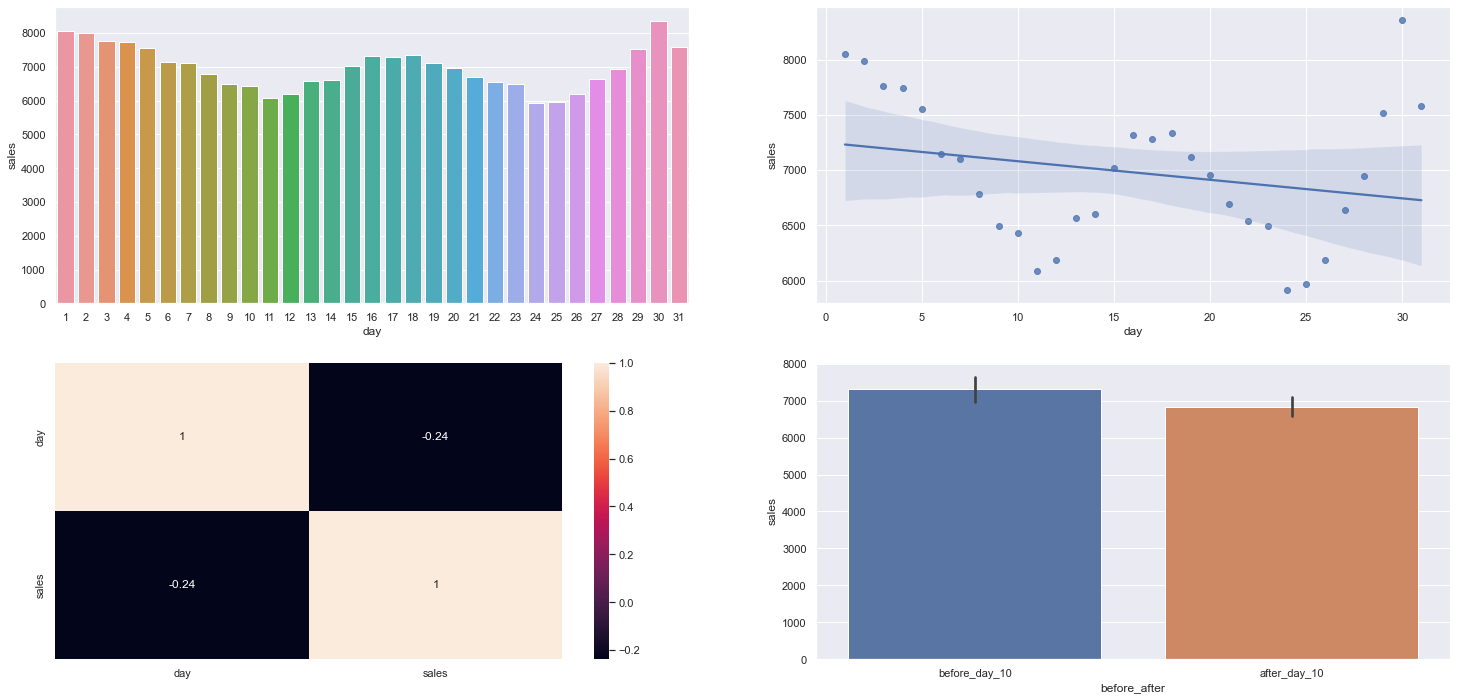

In [40]:
df_day = df4[['day', 'sales']].groupby('day').mean().reset_index()
plt.subplot(2, 2, 1)
sns.barplot(x='day', y='sales', data=df_day)
plt.subplot(2, 2, 2)
sns.regplot(x='day', y='sales', data=df_day)
plt.subplot(2, 2, 3)
sns.heatmap(df_day.corr(method='pearson'),annot=True)

df_day['before_after'] = df_day['day'].apply(lambda x: 'before_day_10' if x <=10 else 'after_day_10')
aux = df_day[['before_after', 'sales']].groupby('before_after').mean().reset_index()
plt.subplot(2, 2, 4)
sns.barplot(x='before_after', y='sales', data=df_day);


#### **H11.** Lojas deveriam vender menos aos finais de semana.
VERDADE -> A média de vendas nos finais de semana é menor. 


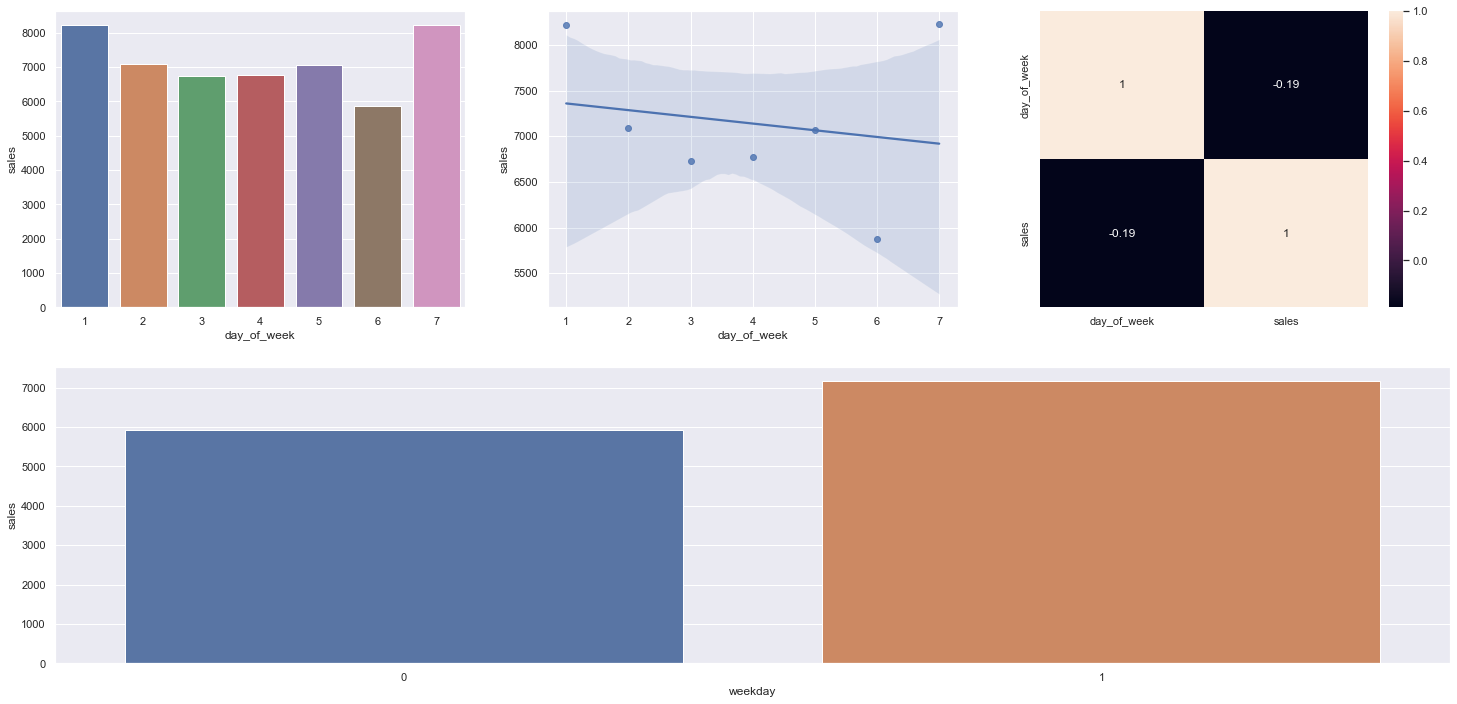

In [41]:
df_aux = df4.copy()
grid = GridSpec(2,3)
df_day_of_week = df4[['day_of_week', 'sales']].groupby('day_of_week').mean().reset_index()
plt.subplot(grid[0, 0])
sns.barplot(x='day_of_week', y='sales', data=df_day_of_week)
plt.subplot(grid[0, 1])
sns.regplot(x='day_of_week', y='sales', data=df_day_of_week)
plt.subplot(grid[0, 2])
sns.heatmap(df_day_of_week.corr(method='pearson'),annot=True)
df_week = df_aux[['weekday', 'sales']].groupby('weekday').mean().reset_index()
plt.subplot(grid[1,:])
sns.barplot(x='weekday', y='sales', data=df_week);

obs: a maior média de vendas é no domingo, mas, como visto anteriormente, a maior parte das lojas não abrem aos domingos - temos poucos dados sobre esse dia da semana.

#### **H12.** Lojas deveriam vender menos durante os feriados escolares.

FALSO -> A média de vendas durante os feriados escolares é maior, exceto em setembro e dezembro.

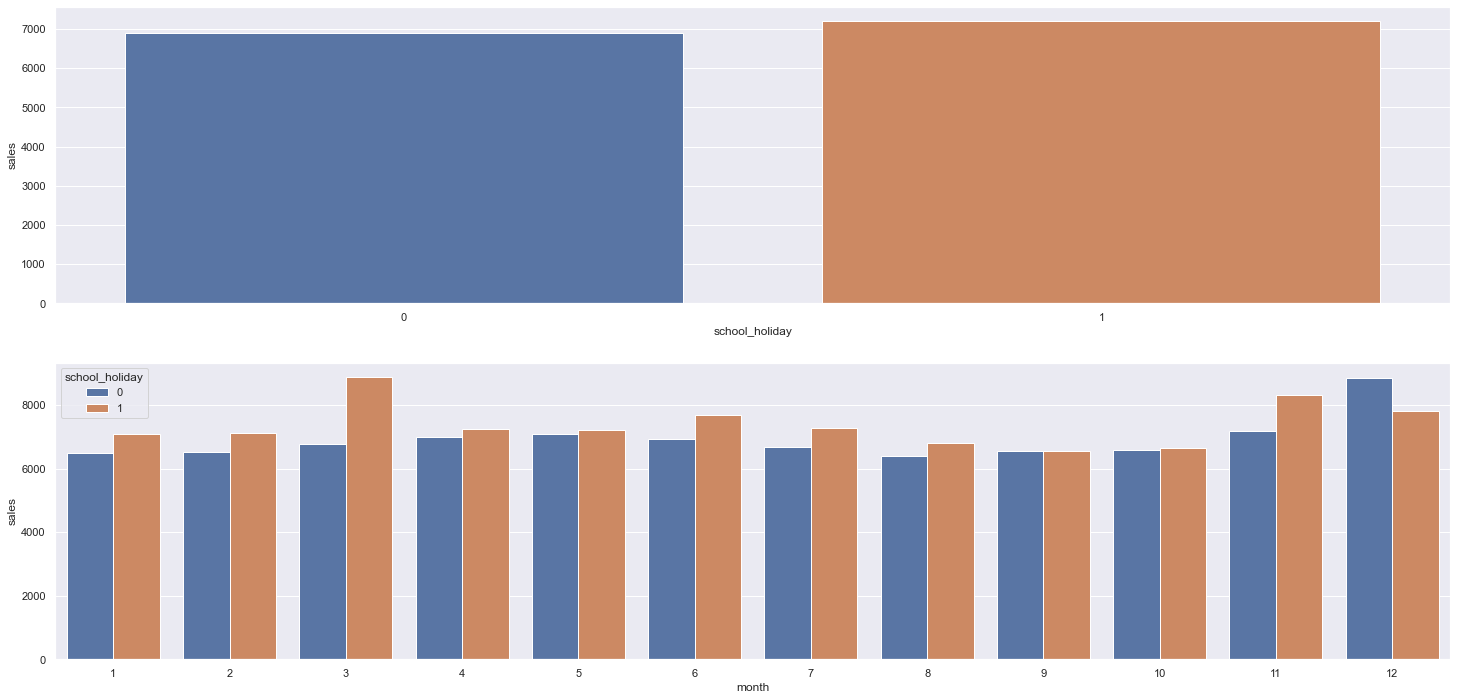

In [42]:
df_sc_hol = df4[['school_holiday', 'sales']].groupby('school_holiday').mean().reset_index()
plt.subplot(2, 1, 1)
sns.barplot(x='school_holiday', y='sales', data=df_sc_hol)

aux = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).mean().reset_index()
plt.subplot(2, 1, 2)
sns.barplot(x='month', hue='school_holiday', y='sales', data=aux);


**H13**: O ticket aumentou ao longo do tempo.

VERDADE: Houve um aumento no ticket médio ao longo do tempo.

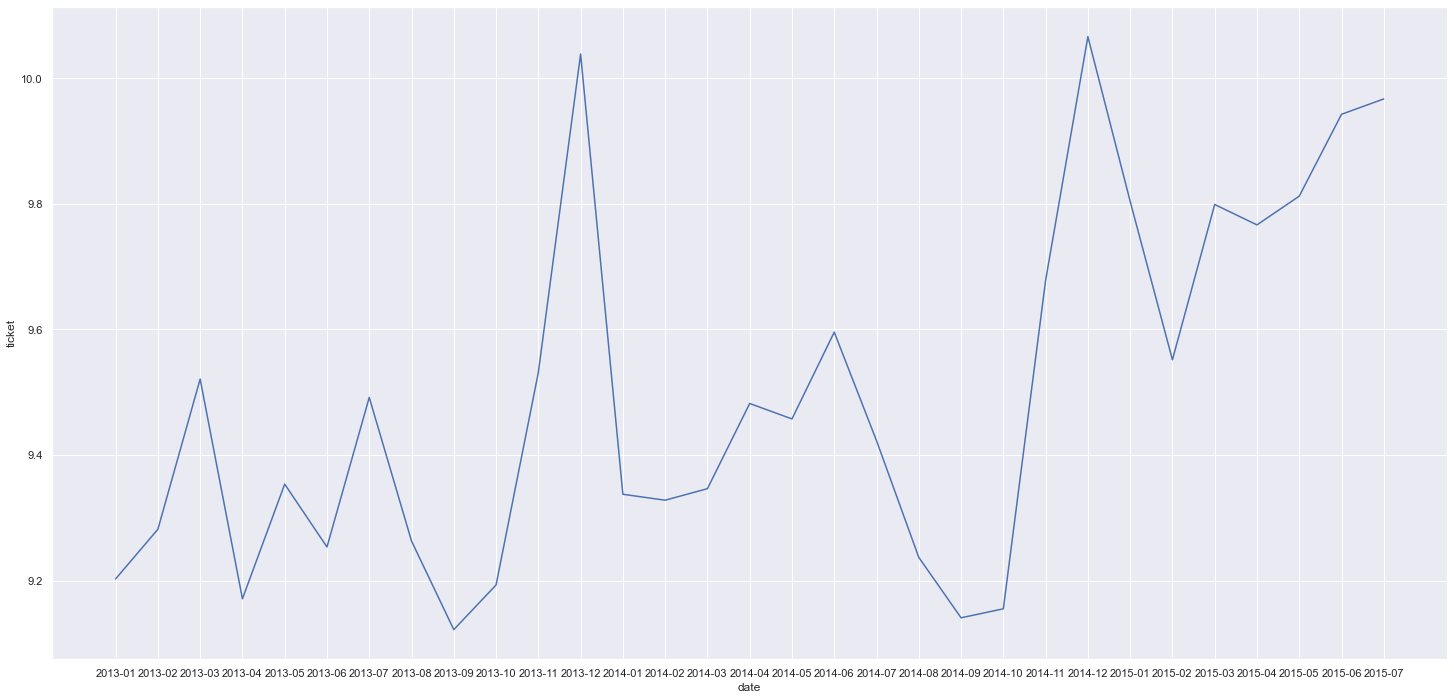

In [43]:
time_ticket = df4[['ticket', 'date', 'year_week']]

plot_df_mon = time_ticket[['date', 'ticket']].groupby(time_ticket.date.dt.strftime('%Y-%m')).mean().reset_index()

sns.lineplot(x='date', y='ticket', data=plot_df_mon);

obs: no gráfico, é possível observar dois picos no ticket médio no mês de dezembro de cada ano (2013 e 2014).

|Hipothesis|Conclusão|Relevância|
|----------|---------|----------|
|H1|Verdadeira|Baixa|
|H2|Falsa|Média|
|H3|Falsa|Média|
|H4|Verdadeira|Baixa|
|H5|Falsa|Baixa|
|H6|Falsa|Baixa|
|H7|Verdadeira|Média|
|H8|Falsa|Alta|
|H9|Verdadeira|Alta|
|H10|Falsa|Alta|
|H11|Verdadeira|Alta|
|H12|Falsa|Baixa|
|H13|Verdade|Média|

### 5.3 Análise Multivariada

#### 5.3.1 Atributos Numéricos

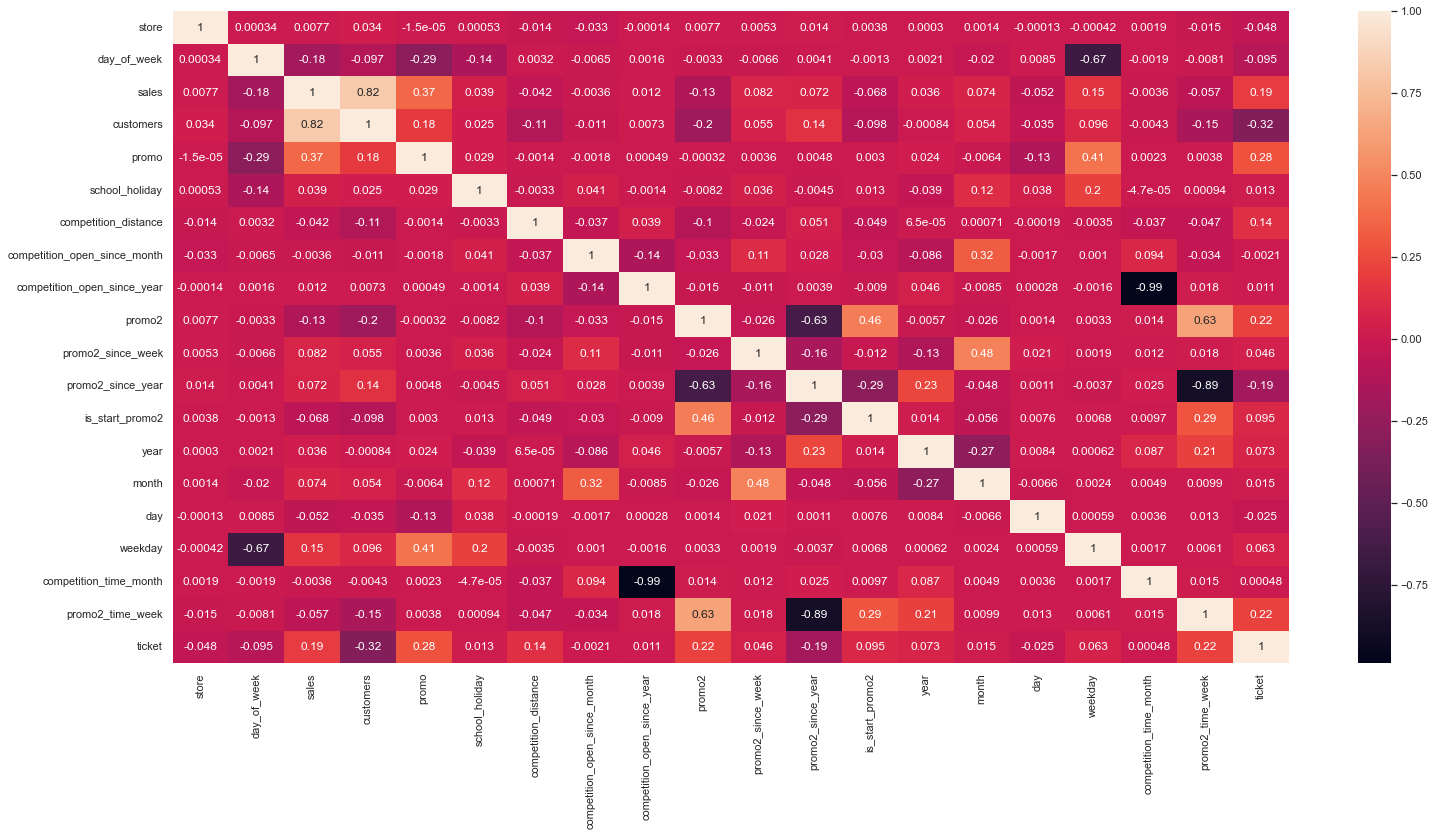

In [44]:
corr = num_attributes.corr(method='pearson')
sns.heatmap(corr, annot=True);

#### 5.3.2 Atributos Categóricos

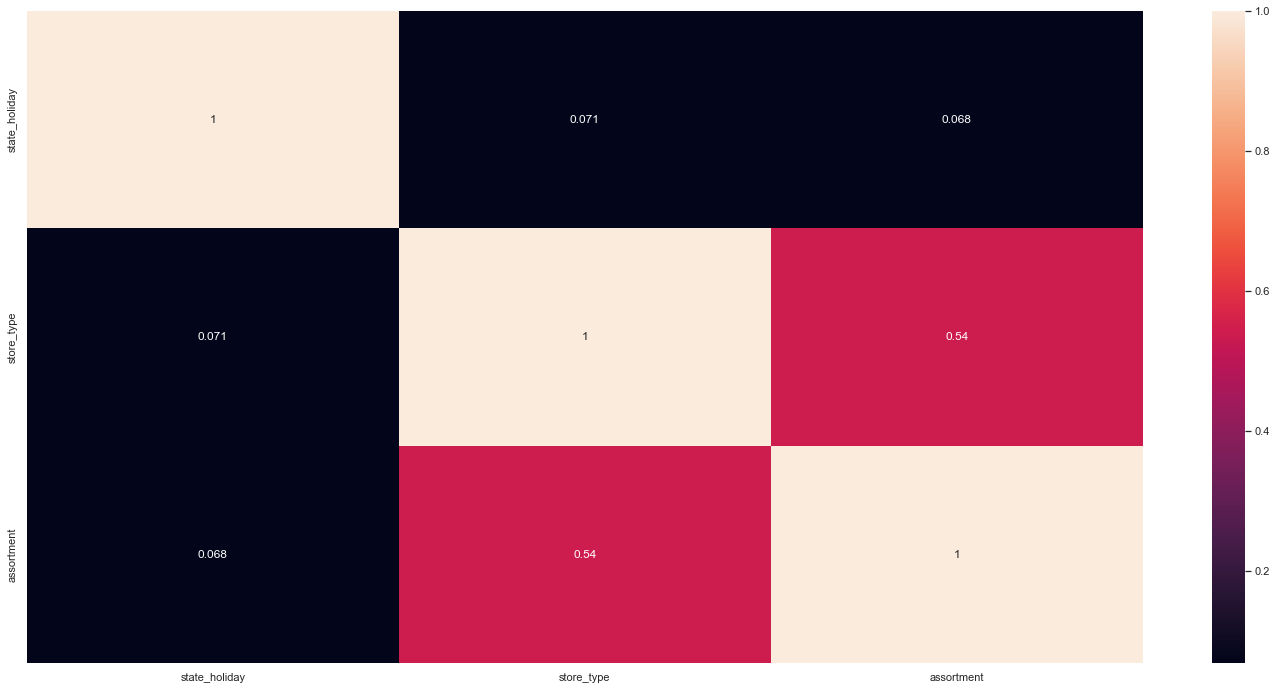

In [45]:
# Cramer V
cat_df = df4.select_dtypes(include='object')

dic = {}
lis = []
for att in ['state_holiday', 'store_type', 'assortment']:
    for att_2 in ['state_holiday', 'store_type', 'assortment']:
        a = cramer_v(cat_df[att], cat_df[att_2])
        lis.append(a)

    lista = lis.copy()
    dic[att] = lista
    lis.clear()

assoc = pd.DataFrame(dic)
assoc = assoc.set_index(assoc.columns)

sns.heatmap(assoc, annot=True);

In [46]:
dic = {}
lis = []
for att in ['state_holiday', 'store_type', 'assortment']:
    for att_2 in ['state_holiday', 'store_type', 'assortment']:
        a = cramer_v(cat_df[att], cat_df[att_2])
        lis.append(a)
        
    lista = lis.copy()
    dic[att] = lista
    lis.clear()
assoc = pd.DataFrame(dic)
assoc = assoc.set_index(assoc.columns)
assoc

,state_holiday,store_type,assortment
state_holiday,1.000000,0.071065,0.067546
store_type,0.071065,1.000000,0.538456
assortment,0.067546,0.538456,1.000000


## 6. Preparação dos Dados

Como a maioria dos algoritmos de machine learning tem o seu aprendizado facilitado com dados numéricos na mesma escala, antes de treinar o modelo, é necessário realizar algumas transformações nos dados.

- Nas variáveis numéricas serão utilizados métodos para deixar os dados em uma mesma escala.

- As variáveis categóricas devem ser transformadas em valores numéricos.

In [47]:
df5 = df4.copy()

### 6.1 Re-escala

### 6.2 Robust and Min-Max Scaler

In [48]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition_distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
#pickle.dump(rs, open('scalers/comp_distance_scaler.pkl', 'wb'))

# competition_time_month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
#pickle.dump(rs, open('scalers/comp_time_month_scaler.pkl', 'wb'))

# year
df5['year'] = mms.fit_transform(df5[['year']].values)
#pickle.dump(mms, open('scalers/year_scaler.pkl', 'wb'))

# promo2_time_week'
df5['promo2_time_week'] = mms.fit_transform(df5[['promo2_time_week']].values)
#pickle.dump(mms, open('scalers/promo_time_week_scaler.pkl', 'wb'))

### 6.3 Transformação

#### 6.3.1 Encoding

In [49]:
# state_holiday One Hot Encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

In [50]:
# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
#pickle.dump(le, open('scalers/store_type_encoder.pkl', 'wb'))

In [51]:
# assortment - Ordinal Enconding
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

#### 6.3.2 Transformação da variável alvo

Transformação logarítmica na variável target para deixá-la com uma distribuição mais próxima da normal. Essa transformação é necessária pois a maioria dos algoritmos esperam que a distribuição da variável seja normal.

In [52]:
# Log transformation
df5['sales'] = np.log1p(df5['sales'])

#### 6.3.3 Transformação Cíclica

Essa transformação faz a representação da natureza repetitiva de uma variável (ciclíca). Ela traz a natureza real de uma variável com uma transformação ciclíca baseada no ciclo trigonométrico.

Ex:
Horas -> Entre 00:00h e 23:00h a distância é de 1 hora, mas sem a transformação o modelo entenderia que 00:00h está a uma distância de 23 horas das 23:00h.

O mesmo vale para dias da semana, meses e semanas.

In [53]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2 * np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2 * np.pi/7)))

# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2 * np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2 * np.pi/12)))

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2 * np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2 * np.pi/30)))

# week of year
df5['week_sin'] = df5['week'].apply(lambda x: np.sin(x * (2 * np.pi/52)))
df5['week_cos'] = df5['week'].apply(lambda x: np.cos(x * (2 * np.pi/52)))

In [54]:
df5.head()

,store,day_of_week,date,sales,customers,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_start_promo2,year,month,day,week,year_week,weekday,competition_since,competition_time_month,promo2_since,promo2_time_week,ticket,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_sin,week_cos
0,1,5,2015-07-31,8.568646,555,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,1,2008-09-01,0.918919,2015-07-27,0.287016,9.482883,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,625,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,1,2007-11-01,1.054054,2010-03-22,0.922551,9.702400,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,821,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,1,2006-12-01,1.202703,2011-03-28,0.801822,10.126675,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1498,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,1,2009-09-01,0.743243,2015-07-27,0.287016,9.342457,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,559,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,1,2015-04-01,-0.162162,2015-07-27,0.287016,8.626118,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


## 7.0 Seleção de Atributos

**Removendo Variáveis Colineares** - Variáveis que trazem a mesma informação.

In [55]:
df6 = df5.copy()

 A coluna com a quantidade de clientes será removida, pois nós não temos essa informação no momento de decisão, ou seja, só sabemos o número de clientes em um dia ao término do expediente.

In [56]:
cols_drop = ['customers', 'year_week', 'day', 'month', 'day_of_week', 'promo2_since', 'competition_since', 'week', 'ticket']
df6 = df6.drop(cols_drop, axis=1)

### 7.1 Separando o dataframe entre treino e teste.

In [57]:
# Temporal -> não dá para separar de forma aleatória (teste últimas seis semanas)
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6*7)

Timestamp('2015-06-19 00:00:00')

In [58]:
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

X_test = df6[df6['date'] > '2015-06-19']
y_test = X_test['sales']

print(f'Data mais antiga do treino: {X_train["date"].min()}\nÚltima data do treino: {X_train["date"].max()}')
print(f'Data mais antiga do teste: {X_test["date"].min()}\nÚltima data do teste: {X_test["date"].max()}')

Data mais antiga do treino: 2013-01-01 00:00:00
Última data do treino: 2015-06-18 00:00:00
Data mais antiga do teste: 2015-06-20 00:00:00
Última data do teste: 2015-07-31 00:00:00


### 7.1 Boruta

Boruta é um selecionador de variáveis que captura as variáveis mais relevantes em relação a variável target.

In [59]:
# Training and test dataset for Boruta
#X_train_n = X_train.drop(['date', 'sales'], axis=1).values
#y_train_n = y_train.values.ravel() # ravel -> coloca dentro de um vetor
#
## Define RandomForestRegressor
#rf = RandomForestRegressor(n_jobs=-1)
#
## Difine Boruto
#boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)

### 7.2 Melhores Atributos pelo Boruta

In [60]:
#cols_selected = boruta.support_.tolist()
##
## best features
#X_train_fs = X_train.drop(['date', 'sales'], axis=1)
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()
##
## Not selected
#cols_not_slected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

### 7.3 Seleção Manual dos Atributos

In [61]:
cols_selected_boruta = [
 'store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'weekday',
 'competition_time_month',
 'promo2_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_cos',
 'month_sin',
 'day_sin',
 'day_cos',
 'week_cos']
 
 # Columns to add
feat_to_add = ['date', 'sales']

# Full Features
cols_selected_boruta_f = cols_selected_boruta.copy()
cols_selected_boruta_f.extend(feat_to_add)

## 8.0 Modelos de Machine Learning

In [62]:
# Training data sem 'date' and 'sale' columns.
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

# Time Series Data Preparation
x_training = X_train[cols_selected_boruta_f]

#### 8.1 Modelo de Média - baseline

In [63]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

#predictions
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1366.128351,0.207912,1854.263316


#### 8.2 Linear Regression Model

In [64]:
# Model
lr = LinearRegression().fit(x_train, y_train)

# Predicton
yhat_lr = lr.predict(x_test)

# Performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1864.115642,0.291701,2669.162638


#### 8.2.1 Linear Regression Model - Validação Cruzada


In [65]:
lr_result_cv = cross_valid_timeseries(x_training, 5, 'Linear Regression', lr, verbose=False)
lr_result_cv

,Model,MAE,MAPE,RMSE
0,Linear Regression,2075.98 +/- 287.0,0.3 +/- 0.0,2945.29 +/- 460.0


#### 8.3 Linear Regression Regularized Model


In [66]:
# Model
lrl = Lasso(alpha=0.0001, max_iter=10000).fit(x_train, y_train) # reduz a influência da features, e pode eliminar algumas (limita os valores) -> ajuda a evitar overfitting


# Predicton
yhat_lrl = lrl.predict(x_test)

# Performance
lrl_result = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrl))
lrl_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1863.684999,0.291181,2670.633938


#### 8.3.1 Linear Regression Regularized Model - Validação Cruzada


In [67]:
lrl_result_cv = cross_valid_timeseries(x_training, 5, 'Lasso', lrl, verbose=False)
lrl_result_cv

,Model,MAE,MAPE,RMSE
0,Lasso,2075.77 +/- 290.0,0.3 +/- 0.0,2948.12 +/- 464.0


#### 8.4 Random Forest Regressor


In [68]:
# Model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, y_train)

# Predicton
yhat_rf = rf.predict(x_test)

# Performance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,700.039625,0.104246,1036.910994


#### 8.4.1 Random Forest Regressor - Validação Cruzada


In [69]:
rf_result_cv = cross_valid_timeseries(x_training, 5, 'Random Forest Regressor', rf, verbose=False)
rf_result_cv

,Model,MAE,MAPE,RMSE
0,Random Forest Regressor,835.33 +/- 213.0,0.12 +/- 0.0,1249.32 +/- 307.0


### 8.5 XGBoost Regressor


In [70]:
# Model
model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                            n_estimators=1000, 
                            eta=0.01,
                            max_depth=5,
                            subsample=0.7,
                            colsample_bytree=0.9).fit(x_train, y_train)

# Predicton
yhat_xgb = model_xgb.predict(x_test)

# Performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,739.570612,0.110346,1067.496714


#### 8.5.1 XGBoost Regressor - Validação Cruzada


In [71]:
xgb_result_cv = cross_valid_timeseries(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=False)
xgb_result_cv

,Model,MAE,MAPE,RMSE
0,XGBoost Regressor,904.88 +/- 108.0,0.13 +/- 0.0,1284.83 +/- 149.0


### 8.6 Comparação de Performance dos Modelos

#### 8.6.1 Performance

In [72]:
models_results = pd.concat([baseline_result, lr_result, lrl_result, rf_result, xgb_result])
models_results.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,700.039625,0.104246,1036.910994
0,XGBoost Regressor,739.570612,0.110346,1067.496714
0,Average Model,1366.128351,0.207912,1854.263316
0,Linear Regression,1864.115642,0.291701,2669.162638
0,Linear Regression - Lasso,1863.684999,0.291181,2670.633938


#### 8.6.1 Performance Real - Validação Cruzada

In [76]:
models_results_cv = pd.concat([lr_result_cv, lrl_result_cv, rf_result_cv, xgb_result_cv])
models_results_cv.sort_values('RMSE')

,Model,MAE,MAPE,RMSE
0,Random Forest Regressor,835.33 +/- 213.0,0.12 +/- 0.0,1249.32 +/- 307.0
0,XGBoost Regressor,904.88 +/- 108.0,0.13 +/- 0.0,1284.83 +/- 149.0
0,Linear Regression,2075.98 +/- 287.0,0.3 +/- 0.0,2945.29 +/- 460.0
0,Lasso,2075.77 +/- 290.0,0.3 +/- 0.0,2948.12 +/- 464.0


## 9.0. Otimização dos Hiperparâmentros

### 9.1. Random Search

É um processo iterativo que, junto com a validação cruzada, encontra a combinação de paramâmetros que melhora o desempenho do modelo.

Os valores para cada um dos hiperparâmetros são definidos aleatoriamente. Os valores que os paramâmetros podem assumir devem ser definidos pelo usuário.


In [79]:
param = {
    'n_estimators': [1500, 1700, 2500, 3000, 3500],
    'eta': [0.01, 0.03],
    'max_depth': [3, 5, 9],
    'subsample': [0.1, 0.5, 0.7],
    'colsample_bytree': [0.3, 0.7, 0.9],
    'min_child_weight': [3, 8, 15]}

MAX_EVAL = 5

In [80]:
#final_result = pd.DataFrame()
#for i in range(MAX_EVAL):
#    # choose values for parameters randomly
#    hp = {k: random.sample(v, 1)[0] for k, v in param.items()}
#    print(hp)
#
#    model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
#                                n_estimators=hp['n_estimators'], 
#                                eta=hp['eta'],
#                                max_depth=hp['max_depth'],
#                                subsample=hp['subsample'],
#                                colsample_bytree=hp['colsample_bytree'],
#                                min_child_weight=hp['min_child_weight'])
#
#  
#
#    # Performance
#    result = cross_valid_timeseries(x_training, 5,'XGBoost Regressor', model_xgb, verbose=False)
#    final_result = pd.concat([final_result, result])
#
#final_result

{'n_estimators': 2500, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.1, 'colsample_bytree': 0.7, 'min_child_weight': 3}
{'n_estimators': 3000, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 8}
{'n_estimators': 1500, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.5, 'colsample_bytree': 0.9, 'min_child_weight': 3}
{'n_estimators': 1500, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.5, 'colsample_bytree': 0.7, 'min_child_weight': 15}
{'n_estimators': 3500, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.1, 'colsample_bytree': 0.7, 'min_child_weight': 15}


,Model,MAE,MAPE,RMSE
0,XGBoost Regressor,1025.58 +/- 130.0,0.14 +/- 0.0,1457.79 +/- 175.0
0,XGBoost Regressor,837.71 +/- 113.0,0.12 +/- 0.0,1201.97 +/- 170.0
0,XGBoost Regressor,1105.86 +/- 124.0,0.15 +/- 0.0,1579.35 +/- 161.0
0,XGBoost Regressor,869.38 +/- 118.0,0.12 +/- 0.0,1242.19 +/- 166.0
0,XGBoost Regressor,994.14 +/- 126.0,0.14 +/- 0.0,1422.29 +/- 177.0


### 9.2. Modelo Final

In [78]:
param_tuned = {
    'n_estimators': 3000,
    'eta': 0.03,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 8}

In [79]:
# Model
model_xgb_tuned = xgb.XGBRegressor(objective='reg:squarederror',
                            n_estimators=param_tuned['n_estimators'], 
                            eta=param_tuned['eta'],
                            max_depth=param_tuned['max_depth'],
                            subsample=param_tuned['subsample'],
                            colsample_bytree=param_tuned['colsample_bytree'],
                            min_child_weight=param_tuned['min_child_weight']).fit(x_train, y_train)


# Prediction
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

# Performance
xgb_result_tuned = ml_error('XGBoost', np.expm1(y_test), np.expm1(yhat_xgb_tuned))

xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost,660.767153,0.097176,954.643536


In [81]:
# pickle.dump(model_xgb_tuned, open(r'model/model_rossman_1.pkl', 'wb'))

## 10.0. Interpretação do Erro


#### Performance do Modelo de Regressão

Entender a performance do modelo e dizer para o CFO o quanto de dinheiro esse modelo vai trazer para a empresa.


MAE (Mean Absolute Error: Erro médio entre a previsão e o valor real -> fácil entendimento do time de negócio.

MAPE (Mean Absolute Percentage Error): Erro médio absoluto em percentagem -> divulgação de resultados.

RMSE (Root Mean Squares Error):  Raíz quadarada do erro quadrático -> medir peroformance do modelo.
        
MPE (Mean Percentage Error): Média do erro percentual -> verificar se o modelo está superestimando ou subestimando.


Performance do Modelo sobre o Negócio

- Comparação com o status quo;
- Incremento de Receita.

In [85]:
df10 = X_test[cols_selected_boruta_f]

# Rescale
df10['sales'] = np.expm1(df10['sales'])
df10['predictions'] = np.expm1(yhat_xgb_tuned)

### 10.1 Performance do Negócio

In [86]:
# Sum of predictions
df101 = df10[['store', 'predictions']].groupby('store').sum().reset_index()

# MAE and MAPE
df10_aux1 = df10[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns={0: 'MAE'})
df10_aux2 = df10[['store', 'sales', 'predictions']].groupby('store').apply(lambda x:mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns={0: 'MAPE'})

# Merge
df10_aux3 = pd.merge(df10_aux1, df10_aux2, how='inner', on='store')
df102 = pd.merge(df101, df10_aux3, how='inner', on='store')

# Scenarios
df102['worst_scenario'] = df102['predictions'] - df102['MAE']
df102['best_scenario'] = df102['predictions'] + df102['MAE']

df102 = df102[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [87]:
df102.sort_values('MAPE', ascending=False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,98045.132812,94614.427314,101475.838311,3430.705499,0.572467
908,909,230358.781250,222585.674849,238131.887651,7773.106401,0.532455
875,876,186994.328125,183088.318226,190900.338024,3906.009899,0.277442
549,550,234520.531250,233152.885145,235888.177355,1367.646105,0.265829
721,722,339906.718750,338015.825345,341797.612155,1890.893405,0.252806


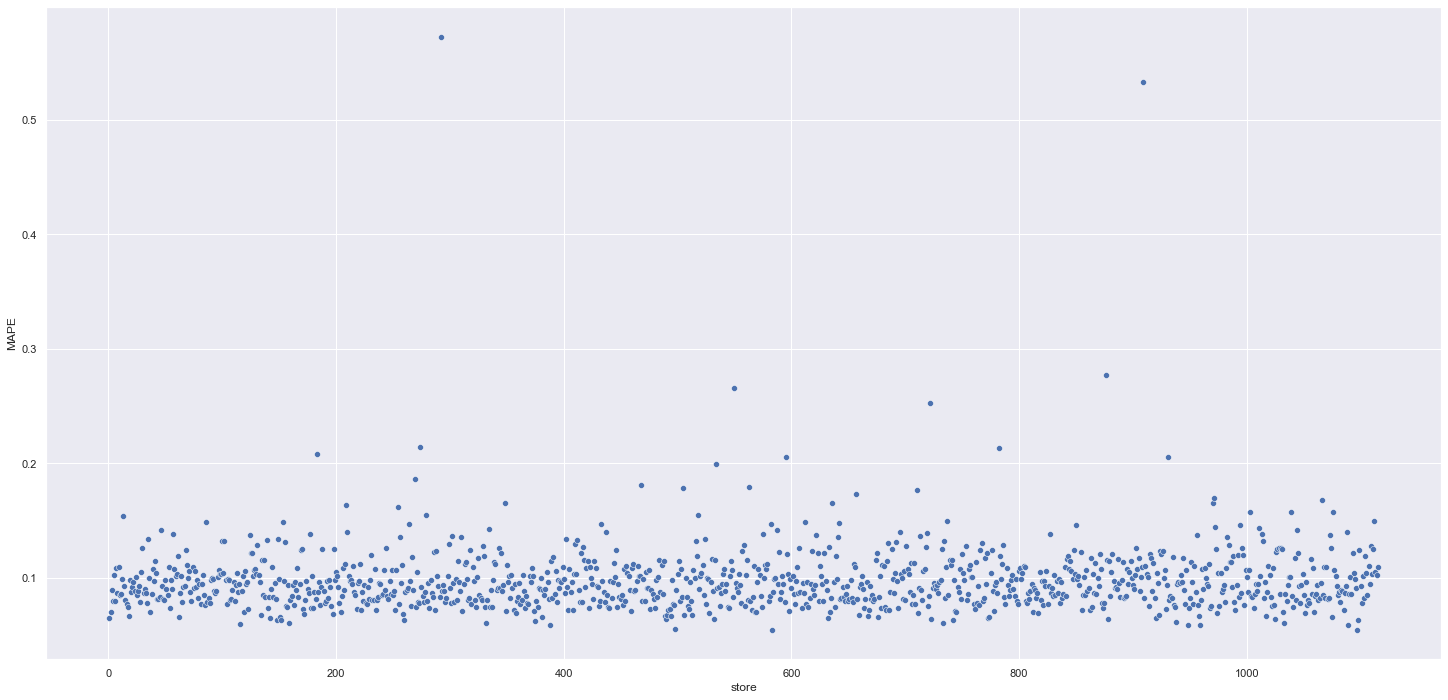

In [88]:
sns.scatterplot(x='store', y='MAPE', data=df102);

### 10.2 Performance Total

In [89]:
df103 = df102[['predictions', 'worst_scenario', 'best_scenario']].apply(lambda x: np.sum(x), axis=0).reset_index().rename(columns={'index': 'Scenario', 0: 'Revenue'})

df103['Revenue'] = df103['Revenue'].map('R$ {:,.2f}'.format)
df103

,Scenario,Revenue
0,predictions,"R$ 276,069,536.00"
1,worst_scenario,"R$ 275,317,393.64"
2,best_scenario,"R$ 276,821,691.31"


### 10.3 Performance do Modelo de Machine Learning 

In [90]:
df10['error'] = df10['sales'] - df10['predictions']
df10['error_rate'] =  df10['predictions']/df10['sales']

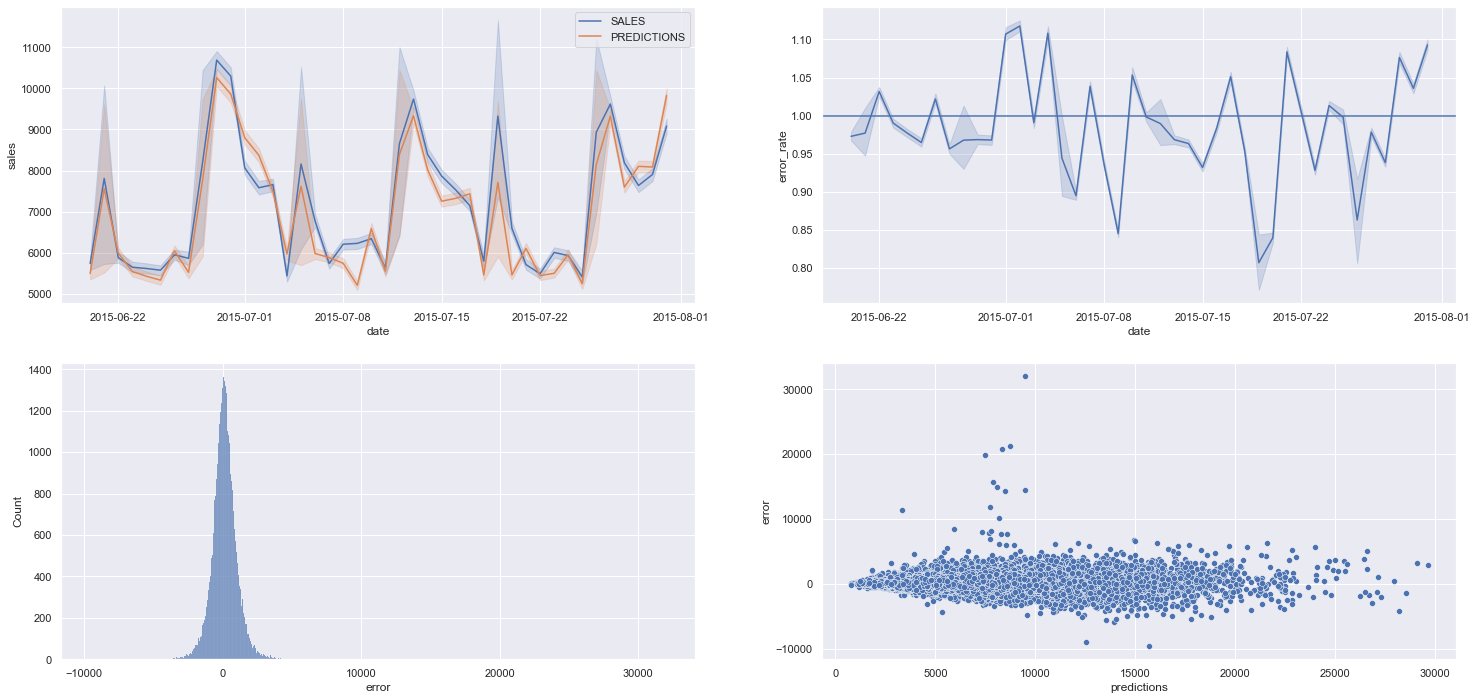

In [91]:
plt.subplot(2, 2, 1)
sns.lineplot(x='date', y='sales', data=df10, label='SALES')
sns.lineplot(x='date', y='predictions', data=df10, label='PREDICTIONS')

plt.subplot(2, 2, 2)
sns.lineplot(x='date', y='error_rate', data=df10)
plt.axhline(1)

plt.subplot(2, 2, 3)
sns.histplot(df10['error'])

# Residual Analysis
plt.subplot(2, 2, 4)
sns.scatterplot(df10['predictions'], df10['error']);